# Project 6: preprocessing and clustering

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import re
from time import time
from fonctions_eda import *
from sklearn.decomposition import PCA
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics.cluster import adjusted_rand_score
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import KeyedVectors
import gensim.downloader as gensim_api
import json
import cv2
import plotly.graph_objs as go
import plotly.express as px
import glob

C:\Users\admin\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


This project was made with Python 3.8.8, **Matplotlib 3.4.2**, Pandas 1.2.4, Numpy 1.20.1, Seaborn 0.11.1. Chek your version number:

In [2]:
print("Python", sys.version_info.major, ".", sys.version_info.minor)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)

Python 3 . 8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1


In [3]:
# For a better visualisation:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":15, "axes.labelsize":14, "xtick.labelsize":14, 
    "ytick.labelsize":14})

## Load dataset

Add the path to the file containing the .csv files of the project:

In [4]:
path_to_txt_folder = "E:/Mes Docs/Sciences/Cours/OpenclassroomsDS-ML/Projet6"
path_to_images_folder = "E:/Mes Docs/Sciences/Cours/OpenclassroomsDS-ML/Projet6/images"

In [5]:
path_txt = os.path.join(path_to_txt_folder, "flipkart_com-ecommerce_sample_1050.csv")

In [6]:
txt = pd.read_csv(path_txt, encoding="utf-8", parse_dates=[1])

## Quick view and basic info

In [7]:
txt.head()

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52+00:00   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0       1899.00            899.00  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1        600.00            449.00  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3       2699.00           1299.00  d4684dcdc759dd9cdf41504698d737d8.jpg   
4       2599.00            698.00  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [8]:
txt.loc[0, "product_url"]

'http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z'

In [9]:
print(f'File has {txt.shape[0]} lines and {txt.shape[1]} columns.')

File has 1050 lines and 15 columns.


In [10]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   uniq_id                  1050 non-null   object             
 1   crawl_timestamp          1050 non-null   datetime64[ns, UTC]
 2   product_url              1050 non-null   object             
 3   product_name             1050 non-null   object             
 4   product_category_tree    1050 non-null   object             
 5   pid                      1050 non-null   object             
 6   retail_price             1049 non-null   float64            
 7   discounted_price         1049 non-null   float64            
 8   image                    1050 non-null   object             
 9   is_FK_Advantage_product  1050 non-null   bool               
 10  description              1050 non-null   object             
 11  product_rating           1050 

In [11]:
print(f'There are {txt.brand.unique().shape[0]} unique brands.')

There are 491 unique brands.


Examples of textual data:

In [12]:
# Examples of products names
txt.loc[0:10, "product_name"]

0     Elegance Polyester Multicolor Abstract Eyelet ...
1                            Sathiyas Cotton Bath Towel
2                   Eurospa Cotton Terry Face Towel Set
3     SANTOSH ROYAL FASHION Cotton Printed King size...
4     Jaipur Print Cotton Floral King sized Double B...
5     Maserati Time R8851116001 Analog Watch  - For ...
6     Camerii WM64 Elegance Analog Watch  - For Men,...
7     T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
8     Alfajr WY16B Youth Digital Watch  - For Men, Boys
9     TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...
10    Calibro SW-125 Analog-Digital Watch  - For Men...
Name: product_name, dtype: object

In [13]:
# Examples of category trees:
txt.loc[0:10, "product_category_tree"]

0     ["Home Furnishing >> Curtains & Accessories >>...
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...
5     ["Watches >> Wrist Watches >> Maserati Time Wr...
6     ["Watches >> Wrist Watches >> Camerii Wrist Wa...
7     ["Watches >> Wrist Watches >> T STAR Wrist Wat...
8     ["Watches >> Wrist Watches >> Alfajr Wrist Wat...
9     ["Watches >> Wrist Watches >> TAG Heuer Wrist ...
10    ["Watches >> Wrist Watches >> Calibro Wrist Wa...
Name: product_category_tree, dtype: object

In [14]:
# Examples of description:
txt.loc[0, "description"]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [15]:
# Examples of product specification:
txt.loc[0, "product_specifications"]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

Many info are formated as strings, category tress are inside a list and product specification seems made to be extracted as a dict (although it if formated as string).

In [16]:
nan_col(txt)

% NaN  % dispo
uniq_id                   0.00   100.00
crawl_timestamp           0.00   100.00
product_url               0.00   100.00
product_name              0.00   100.00
product_category_tree     0.00   100.00
pid                       0.00   100.00
retail_price              0.10    99.90
discounted_price          0.10    99.90
image                     0.00   100.00
is_FK_Advantage_product   0.00   100.00
description               0.00   100.00
product_rating            0.00   100.00
overall_rating            0.00   100.00
brand                    32.19    67.81
product_specifications    0.10    99.90

Most columns are full, only one line has missing info and brand is not always specified.

In [17]:
txt.describe()

retail_price  discounted_price
count       1049.00           1049.00
mean        2186.20           1584.53
std         7639.23           7475.10
min           35.00             35.00
25%          555.00            340.00
50%          999.00            600.00
75%         1999.00           1199.00
max       201000.00         201000.00

In [18]:
pd.DataFrame({"retail_normal":txt.retail_price, "discounted_normal":txt.discounted_price, 
            "retail_log":np.log(txt.retail_price), "dicounted_log":np.log(txt.discounted_price)})

retail_normal  discounted_normal  retail_log  dicounted_log
0           1899.00             899.00        7.55           6.80
1            600.00             449.00        6.40           6.11
2               NaN                NaN         NaN            NaN
3           2699.00            1299.00        7.90           7.17
4           2599.00             698.00        7.86           6.55
...             ...                ...         ...            ...
1045        1399.00             999.00        7.24           6.91
1046        4930.00            1896.00        8.50           7.55
1047        4500.00            1449.00        8.41           7.28
1048        3465.00            1333.00        8.15           7.20
1049        1190.00             595.00        7.08           6.39

[1050 rows x 4 columns]

In [19]:
# Get log values of numerical variables:
x_values = pd.DataFrame({"retail_normal":txt.retail_price, "discounted_normal":txt.discounted_price, 
                        "retail_log":np.log(txt.retail_price), "dicounted_log":np.log(txt.discounted_price)})

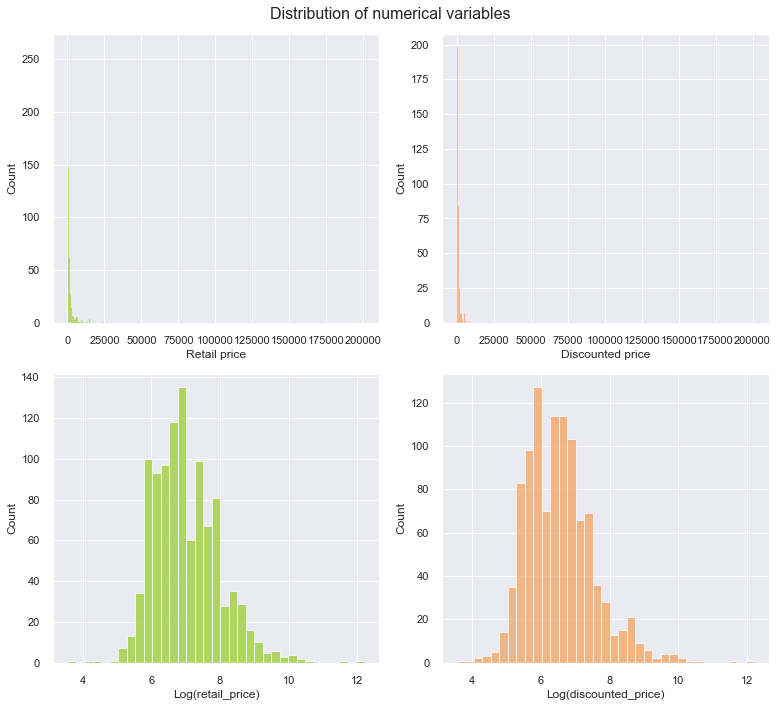

In [20]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(11, 10), tight_layout=True)
fig.suptitle("Distribution of numerical variables")

axes = [(0, 0), (0, 1), (1, 0), (1, 1)]
cols_data = ["retail_price", "discounted_price"] * 2
cols_x = ["retail_normal", "discounted_normal",  "retail_log", "dicounted_log"]
xlabs = ["Retail price", "Discounted price", "Log(retail_price)", "Log(discounted_price)"]
colors=["yellowgreen", "sandybrown"] * 2

for axe, x_value, col_data, col_x, xlab, color in zip(axes, x_values, cols_data, cols_x, xlabs, colors):
    sns.histplot(ax=ax[axe], data=x_values, x=col_x, color=color)
    ax[axe].set_xlabel(xlab)
    

In [21]:
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":15, "axes.labelsize":14, "xtick.labelsize":14, 
    "ytick.labelsize":14})

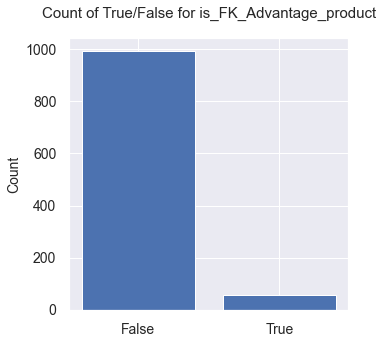

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

data = txt.is_FK_Advantage_product.value_counts()

ax.bar(height=data.values, x=data.index, tick_label=data.index)
ax.set_title("Count of True/False for is_FK_Advantage_product", pad=20)
#ax.set_xticks(["False", "True"])
ax.set_ylabel("Count");

In [23]:
crawl_timestamp_d = txt.groupby(pd.Grouper(key='crawl_timestamp', freq='D')).count()["uniq_id"]

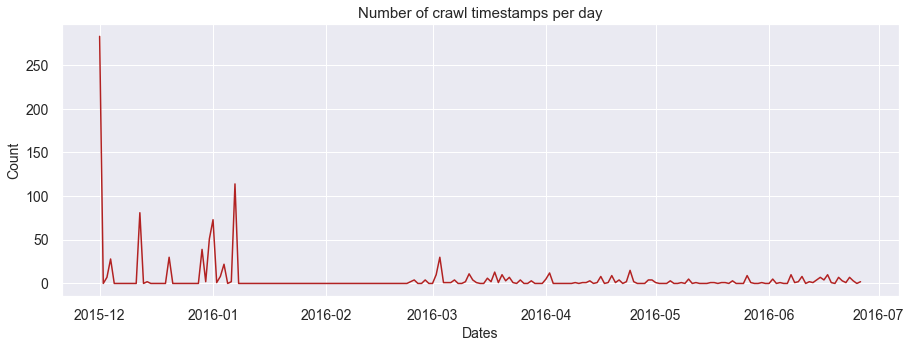

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(crawl_timestamp_d, color="firebrick")
ax.set_title("Number of crawl timestamps per day")
ax.set_xlabel("Dates")
ax.set_ylabel("Count");

## Feature engineering

### Analysis of categories (for supervised learning)

In [25]:
txt.head()

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52+00:00   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0       1899.00            899.00  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1        600.00            449.00  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3       2699.00           1299.00  d4684dcdc759dd9cdf41504698d737d8.jpg   
4       2599.00            698.00  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [26]:
regexp_cat = '\[\"(?P<cat_1>[\w\s&,\']+)>>(?P<cat_2>[\w\s&,\']+)>*(?P<cat_3>[\w\s&,\']*).*'

In [27]:
def get_cat(text, regexp, name):

    """ Test a regexp on a text, if here is a mach return the stripped specified named group."""

    match = re.match(regexp, text)
    if match is None:
        pass
    else:
        return match.group(name).strip()

In [28]:
txt["level_1"] = txt["product_category_tree"].apply(lambda x: get_cat(x, regexp_cat, 'cat_1'))
txt["level_2"] = txt["product_category_tree"].apply(lambda x: get_cat(x, regexp_cat, 'cat_2'))
txt["level_3"] = txt["product_category_tree"].apply(lambda x: get_cat(x, regexp_cat, 'cat_3'))

Objects categories for each level of the category tree:

In [29]:
print(f"There are {txt.level_1.unique().shape[0]} categories of first level.")
print(f"There are {txt.level_2.unique().shape[0]} categories of second level.")
print(f"There are {txt.level_3.unique().shape[0]} categories of third level.")

There are 7 categories of first level.
There are 62 categories of second level.
There are 242 categories of third level.


In [30]:
# Categories first level:
txt.level_1.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [31]:
# Categories second level:
txt.level_2.unique()

array(['Curtains & Accessories', 'Baby Bath & Skin', 'Bed Linen',
       'Wrist Watches', 'Living Room Furnishing', 'Bath Linen',
       'Candles & Fragrances', 'Tableware & Cutlery', 'Lighting',
       'JMD Home Furnishing', 'Infant Wear', "Kripa's Home Furnishing",
       'Hair Care', 'Coffee Mugs', 'Network Components',
       'Tablet Accessories', 'Cookware', 'Laptop Accessories', 'Makeup',
       'Combos and Kits', 'Feeding & Nursing', 'Baby Bedding',
       'Kitchen & Dining Linen', 'Containers & Bottles',
       'Consumables & Disposables', 'Wall Decor & Clocks',
       'Table Decor & Handicrafts', 'Flowers, Plants & Vases', 'Software',
       'Showpieces', 'Furniture & Furnishings',
       'Decorative Lighting & Lamps', 'Baby Grooming',
       'Computer Peripherals', 'Cushions, Pillows & Covers', 'Storage',
       'Health Care', 'Body and Skin Care', 'Kitchen Tools',
       'TRUE Home Decor & Festive Needs', 'Living', 'Showpiece',
       'Bar & Glassware', 'Fragrances', "Women'

In [32]:
# Remplace empty strings by "Unknown"
txt[["level_1", "level_2", "level_3"]] = txt[["level_1", "level_2", "level_3"]].replace("", "Unknown")

In [33]:
nan_col(txt)

% NaN  % dispo
uniq_id                   0.00   100.00
crawl_timestamp           0.00   100.00
product_url               0.00   100.00
product_name              0.00   100.00
product_category_tree     0.00   100.00
pid                       0.00   100.00
retail_price              0.10    99.90
discounted_price          0.10    99.90
image                     0.00   100.00
is_FK_Advantage_product   0.00   100.00
description               0.00   100.00
product_rating            0.00   100.00
overall_rating            0.00   100.00
brand                    32.19    67.81
product_specifications    0.10    99.90
level_1                   0.00   100.00
level_2                   0.00   100.00
level_3                   0.00   100.00

In [34]:
txt.groupby("level_1").count()["uniq_id"]

level_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

There are 150 products for each level 1 category.

In [35]:
level_2_count = txt.groupby("level_2").count()["uniq_id"].copy()
level_2_count.sort_index(inplace=True)
level_2_count.sort_values(ascending=False, inplace=True)
level_2_count_30 = level_2_count[:30]

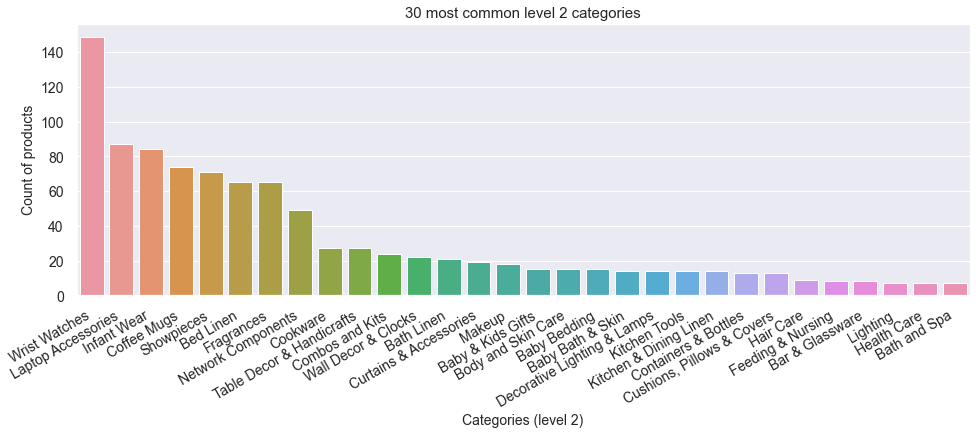

In [36]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(ax=ax, y=level_2_count_30, x=level_2_count_30.index)
ax.set_xticks(range(0, 30))
ax.set_xticklabels(level_2_count_30.index, rotation=30, ha="right")
ax.set_title("30 most common level 2 categories")
ax.set_xlabel("Categories (level 2)")
ax.set_ylabel("Count of products");

Let's make a function to aggregate the text contained in the dataframe and corresponding to a specific category:

In [37]:
# Define stopwords to remove:
sw = nltk.corpus.stopwords.words('english') + ["inch", "com", "and", "cm", "thus"]

# Add some uninformative words:
uninformative_words = ["price", "cash", "delivery", "pack", "flipkart", "buy", "sale", "product", "feature",
    "print", "online", "free", "shipping", "ship"]
sw += uninformative_words

# Define stemmer
stemmer = nltk.stem.SnowballStemmer("english")

# Define lemmatizer:
lem = nltk.stem.WordNetLemmatizer()

In [38]:
def agg_pd_txt(df, col_cond, value, col_toagg):

    """ 
    Aggregate string values from a dataframe selected from a condition. Return a single string.
    df: dataframe containing the data.
    col_cond: (str) column to use in the selection condition.
    value: (str) value of the condition.
    col_toagg : column containing strings to aggregate.
    
    """
    result = df[df[col_cond]==value][col_toagg]
    result = result.agg("sum").lower()
    return result

In [39]:
def clean_non_words(text, lower=True):
    """Remove all non-alphabetical characters and 1-2 letters words, pass text to lower case if lower is set to True."""
    if lower:
        text = text.lower()
    else: pass
    # Select only words:
    text = re.sub("[^a-z]+", " ", text)
    # Only words of 3 characters or more:
    text = re.sub(r"\b\w{1}\b", "", text)
    text = re.sub(r"\b\w{2}\b", "", text)
    # Clean multiple whitespaces:
    text = re.sub(r" +", " ", text)
    text = text.strip()
    return text

In [40]:
def tokenize_clean_sw_stem(text, stopwords, stemmer):
    """Tokenize with simple split, remove stopwords, stem."""
    # Tokenize
    text = text.split()
    # Stemming
    text = [stemmer.stem(w) for w in text]
    # Remove stopwords
    text = [w for w in text if w not in stopwords]
    return text

In [41]:
def tokenize_clean_sw_lemmatize(text, stopwords, lemmatizer):
    """Tokenize with simple split, remove stopwords, lemmatize with tags."""
    # Tokenize
    text = text.split()

    # Tag text and lemmatize accordingly
    tagged_text = nltk.pos_tag(text)
    lemmatized_text=[]
    for word, tag in tagged_text:
        if tag.startswith('J'):
            lemmatized_text.append(lem.lemmatize(word,'a'))
        elif tag.startswith('V'):
            lemmatized_text.append(lem.lemmatize(word,'v'))
        elif tag.startswith('N'):
            lemmatized_text.append(lem.lemmatize(word,'n'))
        elif tag.startswith('R'):
            lemmatized_text.append(lem.lemmatize(word,'r'))
        else:
            lemmatized_text.append(lem.lemmatize(word))

    # Remove stopwords
    lemmatized_text = [w for w in lemmatized_text if w not in stopwords]

    return lemmatized_text

In [42]:
# Create dictionnariesthat will contain corpus:
products_names = {"furnishing":"", "baby":"", "watches":"", "decor":"", 
    "kitchen":"", "beauty":"", "computers":""}

descriptions = {"furnishing":"", "baby":"", "watches":"", "decor":"", 
    "kitchen":"", "beauty":"", "computers":""}

# List categories:
categories = ["Home Furnishing", "Baby Care", "Watches", "Home Decor & Festive Needs", 
    "Kitchen & Dining", "Beauty and Personal Care", "Computers"]

In [43]:
# Put corpus in dictionnaries for products names and descriptions:

for key, cat in zip(products_names.keys(), categories):
    # Aggregate text:
    products_names[key] = agg_pd_txt(txt,"level_1", cat, "product_name")
    # Clean non-alphabetical characters and less than 3 letters words:
    products_names[key] = clean_non_words(products_names[key])
    # Tokenize, clean stopwords, stem:
    products_names[key] = tokenize_clean_sw_stem(products_names[key], sw, stemmer)

for key, cat in zip(descriptions.keys(), categories):
    descriptions[key] = agg_pd_txt(txt,"level_1", cat, "description")
    descriptions[key] = clean_non_words(descriptions[key])
    descriptions[key] = tokenize_clean_sw_stem(descriptions[key], sw, stemmer)

In [44]:
descriptions["furnishing"]

['key',
 'featur',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'curtain',
 'enhanc',
 'look',
 'interior',
 'curtain',
 'made',
 'high',
 'qualiti',
 'polyest',
 'fabric',
 'featur',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environ',
 'romant',
 'love',
 'curtain',
 'ant',
 'wrinkl',
 'anti',
 'shrinkag',
 'eleg',
 'appar',
 'give',
 'home',
 'bright',
 'modernist',
 'appeal',
 'design',
 'surreal',
 'attent',
 'sure',
 'steal',
 'heart',
 'contemporari',
 'eyelet',
 'valanc',
 'curtain',
 'slide',
 'smooth',
 'draw',
 'apart',
 'first',
 'thing',
 'morn',
 'welcom',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morn',
 'whole',
 'world',
 'draw',
 'close',
 'even',
 'creat',
 'special',
 'moment',
 'joyous',
 'beauti',
 'given',
 'sooth',
 'bring',
 'home',
 'eleg',
 'curtain',
 'soft',
 'filter

Stemming give words whose meaning is not clear and may be misleading ("eleg", "singl", "enhanc"). We will rather use the lemmatizer that usually gives better results.

In [45]:
# Clean dictionnaries
products_names = {"furnishing":"", "baby":"", "watches":"", "decor":"", 
    "kitchen":"", "beauty":"", "computers":""}

descriptions = {"furnishing":"", "baby":"", "watches":"", "decor":"", 
    "kitchen":"", "beauty":"", "computers":""}

In [46]:
# Same steps but with lemmatizer:

for key, cat in zip(products_names.keys(), categories):
    products_names[key] = agg_pd_txt(txt,"level_1", cat, "product_name")
    products_names[key] = clean_non_words(products_names[key])
    products_names[key] = tokenize_clean_sw_lemmatize(products_names[key], sw, lem)

for key, cat in zip(descriptions.keys(), categories):
    descriptions[key] = agg_pd_txt(txt,"level_1", cat, "description")
    descriptions[key] = clean_non_words(descriptions[key])
    descriptions[key] = tokenize_clean_sw_lemmatize(descriptions[key], sw, lem)

In [47]:
descriptions["furnishing"]

['key',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'curtain',
 'enhance',
 'look',
 'interior',
 'curtain',
 'make',
 'high',
 'quality',
 'polyester',
 'fabric',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'romantic',
 'love',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moment',
 'joyous',
 'beauty',
 'give',
 'soothe',
 'bring',
 'home',
 'elegant',

Words are quite well lemmatized. Compared to the stemming approach, "eleg" is now "elegance", "enhanc" become "enhance", etc...

In [48]:
descriptions_freq = dict()
total, unique = [], []

for k, v in zip(descriptions.keys(), descriptions.values()):
    descriptions_freq[k] = fq =  nltk.FreqDist(v)
    total.append(len(v))
    unique.append(len(fq.keys()))

descriptions_n_words = pd.DataFrame({"total":total, "unique":unique}, index=descriptions.keys())
descriptions_n_words.sort_values(by="total", ascending=False, inplace=True)

In [49]:
products_names_freq = dict()
total, unique = [], []

for k, v in zip(products_names.keys(), products_names.values()):
    products_names_freq[k] = fq =  nltk.FreqDist(v)
    total.append(len(v))
    unique.append(len(fq.keys()))

products_names_n_words = pd.DataFrame({"total":total, "unique":unique}, index=descriptions.keys())
products_names_n_words.sort_values(by="total", ascending=False, inplace=True)

In [50]:
descriptions_n_words

total  unique
kitchen      8835    1143
baby         7759    1208
decor        7629    1447
computers    7625    1017
furnishing   5191     816
beauty       4966    1165
watches      4040     475

In [51]:
products_names_n_words

total  unique
beauty        878     446
decor         814     413
computers     783     321
baby          741     352
furnishing    718     247
watches       683     221
kitchen       645     329

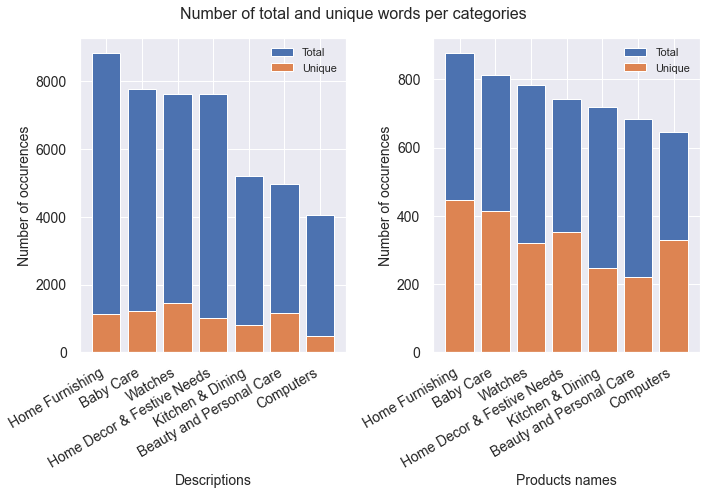

In [52]:
fig, ax = plt.subplots (1, 2, figsize=(10, 7), tight_layout=True)
fig.suptitle("Number of total and unique words per categories")

datas = [descriptions_n_words, products_names_n_words]
xlabels = ["Descriptions", "Products names"]

for axe, data, xlab in zip([0, 1], datas, xlabels):
    ax[axe].bar(height=data["total"], x=categories, label="Total")
    ax[axe].bar(height=data["unique"], x=categories, label="Unique")
    ax[axe].set_ylabel("Number of occurences")
    ax[axe].set_xlabel(xlab)
    ax[axe].set_xticks(categories)
    ax[axe].set_xticklabels(categories, rotation=30, ha="right")
    ax[axe].legend()

In [53]:
furnishing_desc_freq = pd.Series(descriptions_freq["furnishing"])
furnishing_desc_freq.sort_values(ascending=False, inplace=True)

furnishing_names_freq = pd.Series(products_names_freq["furnishing"])
furnishing_names_freq.sort_values(ascending=False, inplace=True)

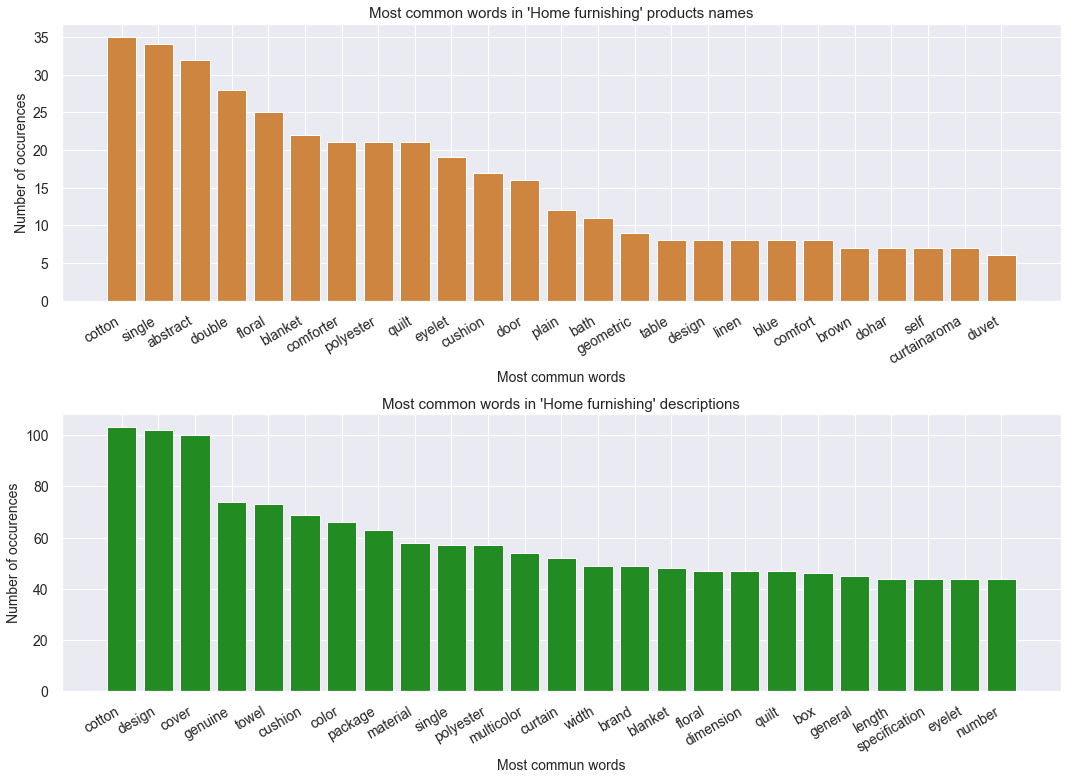

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(15, 11), tight_layout=True)
datas = [furnishing_names_freq, furnishing_desc_freq]
titles = ["Most common words in 'Home furnishing' products names", "Most common words in 'Home furnishing' descriptions"]
xlabels = ["Products names", "Descriptions"]
colors = ["peru", "forestgreen"]

for axe, data, title, xlab, color in zip([0, 1], datas, titles, xlabels, colors):
    ax[axe].bar(height=data[:25], x=data[:25].index, color=color)
    ax[axe].set_title(title)
    ax[axe].set_ylabel("Number of occurences")
    ax[axe].set_xlabel("Most commun words")
    ax[axe].set_xticks(data[:25].index)
    ax[axe].set_xticklabels(data[:25].index, rotation=30, ha="right");

### Whole dataset analysis (for unsupervised learning)

We will use both product name and text description in order to maximise the informative value of our texts.

In [55]:
# Aggregate product names and descriptions in a new column:
txt["name_description"] = txt["product_name"] + txt["description"]

In [56]:
# Keep only relevant columns for text analysis:
txt_clean = txt[["image", "product_name", "description", "level_1", "level_2", "level_3", "name_description"]].copy()
txt_clean.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description          level_1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                  level_2           level_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   
3               Bed Linen         Bedsheets   
4               Bed Linen         Bedsheets   

                                    name_description  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath TowelSpecifications of Sa...  
2  Eurospa Cotton Terry Face Towel SetKey Feature...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

In [57]:
# Make a vocabulary set on the whole corpus using our cleaning/tokenizing/lemmatizing functions:
vocabulary = txt["name_description"].agg("sum").lower()
vocabulary = clean_non_words(vocabulary)
vocabulary = tokenize_clean_sw_lemmatize(vocabulary, sw, lem)
#vocabulary = set(vocabulary)

In [58]:
whole_corpus_fq = nltk.FreqDist(vocabulary)
whole_corpus_fq = pd.Series(whole_corpus_fq)
whole_corpus_fq.sort_values(ascending=False, inplace=True)

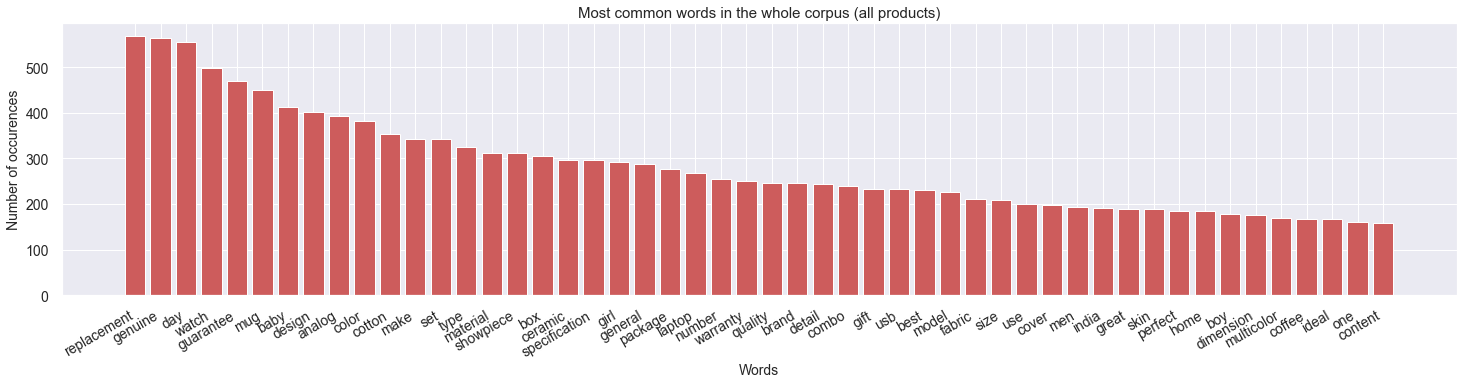

In [59]:
fig, ax = plt.subplots(figsize=(25, 5))

ax.bar(height=whole_corpus_fq[:50], x=whole_corpus_fq[:50].index, color="indianred")
ax.set_title("Most common words in the whole corpus (all products)")
ax.set_xlabel("Words")
ax.set_ylabel("Number of occurences")
ax.set_xticks(whole_corpus_fq[:50].index)
ax.set_xticklabels(whole_corpus_fq[:50].index, rotation=30, ha="right");

In [60]:
# Make copies of our corpus
corpus = txt["name_description"].to_numpy().copy()
corpus_series = txt["name_description"].copy()

In [61]:
clean_corpus = []
for document in corpus:
    document = clean_non_words(document)
    document = tokenize_clean_sw_lemmatize(document, sw, lem)
    clean_corpus.append(document)

### Bag of words

Our first approach is to use a bag of words for each document (product name + description) of the corpus.

We will use our own preprocessing from the functions defined above. We will limitate our BoW to 2500 words (`max_features`).

In [62]:
# Define our preprocessing function:
def txt_preprocessing(text):
    """
    Clean non-words (that include numbers or punctuation and are less than 3 letters).
    Pass text to lower case, tokenize, remove stopwords, lemmatize with tagging.
    """
    text = clean_non_words(text)
    text = tokenize_clean_sw_lemmatize(text, sw, lem)
    return text

In [63]:
# Define count vectorizer to create sparse matrix and fit it:
cv = CountVectorizer(analyzer=txt_preprocessing, max_features=2500)
bow_matrix = cv.fit_transform(corpus).toarray()
# Check shape
bow_matrix.shape

(1050, 2500)

In [64]:
# Get words and make a dataframe for readability:
bow_df = pd.DataFrame(bow_matrix, columns=cv.get_feature_names())
bow_df.head()

aapno  aari  ability  abkl  able  abode  absorb  absorbency  absorbent  \
0      0     0        0     0     0      0       0           0          0   
1      0     0        0     0     0      0       0           0          0   
2      0     0        0     0     0      0       0           1          0   
3      0     0        0     0     0      0       0           0          0   
4      0     0        0     0     0      0       0           0          0   

   abstract  accent  accessory  accord  aci  acne  across  acrylic  act  \
0         5       0          0       0    0     0       0        0    0   
1         0       0          0       0    0     0       0        0    0   
2         0       0          0       0    0     0       0        0    0   
3         0       0          0       0    0     0       0        0    0   
4         0       0          0       0    0     0       0        0    0   

   actual  adaa  adapter  adapterkey  adaptor  add  addition  additional  adf  \
0       0     0        0           0        0    0         0           0    0   
1       0     0        0           0        0    0         0           0    0   
2       0     0        0           0        0    0         0           0    0   
3       0     0        0           0        0    0         0           0    0   
4       0     0        0           0        0    0         0           0    0   

   adhesive  adi  adidas  adjustable  admire  adorable  adorn  adsl  advance  \
0         0    0       0           0       0         0      0     0        0   
1         0    0       0           0       0         0      0     0        0   
2         0    0       0           0       0         0      0     0        0   
3         0    0       0           0       0         0      0     0        0   
4         0    0       0           0       0         0      0     0        0   

   advice  aero  affect  affordable  age  agrasen  agromech  aid  air  airtex  \
0       0     0       0           0    0        0         0    0    0       0   
1       0     0       0           0    0        0         0    0    0       0   
2       0     0       0           0    0        0         0    0    0       0   
3       0     0       0           0    0        0         0    0    0       0   
4       0     0       0           0    0        0         0    0    0       0   

   akada  akshaj  akup  alarm  aleo  alfajr  allin  allow  alloy  ally  \
0      0       0     0      0     0       0      0      0      0     0   
1      0       0     0      0     0       0      0      0      0     0   
2      0       0     0      0     0       0      0      0      0     0   
3      0       0     0      0     0       0      0      0      0     0   
4      0       0     0      0     0       0      0      0      0     0   

   almond  aloe  aloevera  along  also  aluminium  always  amaze  amazing  \
0       0     0         0      0     0          0       0      0        0   
1       0     0         0      0     0          0       0      0        0   
2       0     0         0      0     0          0       0      0        0   
3       0     0         0      0     0          0       0      0        0   
4       0     0         0      0     0          0       0      0        0   

   amazwh  amit  ammonia  amount  amplify  analog  andre  andriod  android  \
0       0     0        0       1        0       0      0        0        0   
1       0     0        0       0        0       0      0        0        0   
2       0     0        0       0        0       0      0        0        0   
3       0     0        0       0        0       0      0        0        0   
4       0     0        0       0        0       0      0        0        0   

   angel  animal  anjalika  anna  anodise  anodize  another  ant  anti  \
0      0       0         0     0        0        0        0    1     1   
1      0       0         0     0        0        0        0    0     0   
2      0       0         0     0   

As expected, we get a very sparse matrix of 1050 lines (products) x 2500 columns (words).

### Tf-idf

#### Tf-idf with min_df parameter set

We will use tf-idf method to extract features from our texts and get a matrix that we will use in a t-SNE visualization (therefore with dimensions reduction).

In [65]:
# Define our tf-idf vectorizer
vectoriser = TfidfVectorizer(analyzer=txt_preprocessing, min_df=0.0015)

In [66]:
# Fit-transform and get our tf_idf matrix
tf_idf_result = vectoriser.fit_transform(corpus)
tf_idf_df=pd.DataFrame(tf_idf_result.toarray(),columns=vectoriser.get_feature_names())
tf_idf_df

aapno  ability  abkl  able  abode  absorb  absorbency  absorbent  \
0      0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
1      0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
2      0.00     0.00  0.00  0.00   0.00    0.00        0.07       0.00   
3      0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
4      0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
...     ...      ...   ...   ...    ...     ...         ...        ...   
1045   0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
1046   0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
1047   0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
1048   0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   
1049   0.00     0.00  0.00  0.00   0.00    0.00        0.00       0.00   

      abstract  abuy  accent  access  accessory  accident  accidental  accord  \
0         0.21  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
1         0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
2         0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
3         0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
4         0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
...        ...   ...     ...     ...        ...       ...         ...     ...   
1045      0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
1046      0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
1047      0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
1048      0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   
1049      0.00  0.00    0.00    0.00       0.00      0.00        0.00    0.00   

      across  act  actual  adapter  adapterkey  adaptor  add  addition  \
0       0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
1       0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
2       0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
3       0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
4       0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
...      ...  ...     ...      ...         ...      ...  ...       ...   
1045    0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
1046    0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
1047    0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
1048    0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   
1049    0.00 0.00    0.00     0.00        0.00     0.00 0.00      0.00   

      additional  adhesive  adidas  adjust  adjustable  admire  adorable  \
0           0.00      0.00    0.00    0.00        0.00    0.00      0.00   
1           0.00      0.00    0.00    0.00        0.00    0.00      0.00   
2           0.00      0.00    0.00    0.00        0.00    0.00      0.00   
3           0.00      0.00    0.00    0.00        0.00    0.00      0.00   
4           0.00      0.00    0.00    0.00        0.00    0.00      0.00   
...          ...       ...     ...     ...         ...     ...       ...   
1045        0.00      0.08    0.00    0.00        0.00    0.00      0.00   
1046        0.00      0.12    0.00    0.00        0.00    0.00      0.00   
1047        0.00      0.00    0.00    0.00        0.00    0.00      0.00   
1048        0.00      0.00    0.00    0.00        0.00    0.00      0.00   
1049        0.00      0.00    0.00    0.00        0.00    0.00      0.00   

      adorn  adsl  advice  aero  affect  affordable  age  aid  air  akup  \
0      0.00  0.00    0.00  0.00    0.00        0.00 0.00 0.00 0.00  0.00   
1      0.00  0.00    0.00  0.00    0.00        0.00 0.00 0.00 0.00  0.00   
2      0.00  0.00    0.00  0.00    0.00        0.00 0.00 0.00 0.00  0.00   
3      0.00  0.00    0.00  0.00    0.0

In [67]:
print(f"We treated {tf_idf_df.shape[0]} products and kept {tf_idf_df.shape[1]} words.")

We treated 1050 products and kept 2074 words.


The resulting matrix is very sparse, with a lot of 0 or very small values. Let's have a look at the stop-words set aside by our `min_df` value:

In [68]:
vectoriser.stop_words_

{'casa',
 'drubuy',
 'drop',
 'richfeel',
 'quiz',
 'shopoj',
 'vdsl',
 'packaging',
 'smell',
 'metalic',
 'upwards',
 'stucco',
 'feetje',
 'melange',
 'anise',
 'towelspecifications',
 'suruchi',
 'womenrrtc',
 'belkin',
 'fabutex',
 'strblue',
 'fade',
 'cmx',
 'soup',
 'colorkey',
 'greenaurraa',
 'girlssrushti',
 'template',
 'demand',
 'reduces',
 'girlssonata',
 'blind',
 'story',
 'tuft',
 'applicable',
 'simoco',
 'vapour',
 'degrees',
 'signal',
 'memo',
 'bookmark',
 'carefully',
 'warn',
 'ncbuy',
 'infinity',
 'backing',
 'testimony',
 'official',
 'anjalika',
 'emboss',
 'ppgn',
 'dhyan',
 'ppsn',
 'condensation',
 'returnfavors',
 'womenlogues',
 'sunshield',
 'pktbl',
 'rastogi',
 'computrised',
 'airtel',
 'botanically',
 'epresent',
 'stor',
 'camp',
 'dell',
 'fairy',
 'everyones',
 'petrol',
 'evening',
 'mahavastu',
 'mly',
 'swampy',
 'saffron',
 'waveform',
 'versatility',
 'wallskart',
 'houseattire',
 'vii',
 'dap',
 'colur',
 'peppergood',
 'blow',
 'flu',
 '

Most of them seem typo mistakes from the preprocessing, although some real words were also set aside.

#### Tf-idf with max 200 features

In [69]:
# Define our tf-idf vectorizer
vectoriser = TfidfVectorizer(analyzer=txt_preprocessing, max_features=200)

In [70]:
# Fit-transform and get our tf_idf matrix
tf_idf_result = vectoriser.fit_transform(corpus)
tf_idf_200=pd.DataFrame(tf_idf_result.toarray(),columns=vectoriser.get_feature_names())
tf_idf_200

abstract  adapter  add  additional  also  analog  art  baby  back  bath  \
0         0.24     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.65   
2         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.13   
3         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
4         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
...        ...      ...  ...         ...   ...     ...  ...   ...   ...   ...   
1045      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.09  0.00   
1046      0.00     0.00 0.00        0.00  0.13    0.00 0.16  0.00  0.00  0.00   
1047      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1048      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1049      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   

      battery  beautiful  bed  bedsheet  best  black  blanket  blue  body  \
0        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.04   
1        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.16  0.00   
2        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.00   
3        0.00       0.00 0.00      0.54  0.00   0.00     0.00  0.00  0.00   
4        0.00       0.00 0.30      0.33  0.00   0.00     0.00  0.00  0.00   
...       ...        ...  ...       ...   ...    ...      ...   ...   ...   
1045     0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.00   
1046     0.00       0.00 0.00      0.00  0.09   0.00     0.00  0.00  0.00   
1047     0.00       0.00 0.00      0.00  0.24   0.00     0.00  0.00  0.00   
1048     0.00       0.00 0.00      0.00  0.10   0.00     0.00  0.00  0.00   
1049     0.00       0.00 0.00      0.00  0.24   0.00     0.00  0.00  0.00   

      bottle  box  boy  boys  brand  brass  bring  brown  capacity  care  \
0       0.00 0.03 0.00  0.00   0.03   0.00   0.05   0.00      0.00  0.00   
1       0.00 0.05 0.08  0.00   0.05   0.00   0.00   0.00      0.00  0.00   
2       0.00 0.03 0.00  0.06   0.07   0.00   0.06   0.00      0.00  0.10   
3       0.00 0.04 0.00  0.00   0.04   0.00   0.00   0.00      0.00  0.06   
4       0.00 0.03 0.00  0.00   0.03   0.00   0.00   0.00      0.00  0.04   
...      ...  ...  ...   ...    ...    ...    ...    ...       ...   ...   
1045    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1046    0.00 0.00 0.00  0.00   0.00   0.00   0.15   0.00      0.00  0.00   
1047    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1048    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1049    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   

      case  casual  cell  ceramic  charger  clean  cmbuy  code  coffee  \
0     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
2     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
3     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
4     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
...    ...     ...   ...      ...      ...    ...    ...   ...     ...   
1045  0.00    0.00  0.00     0.00     0.00   0.10   0.00  0.00    0.00   
1046  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1047  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1048  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1049  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   

      collection  color  colour  combo  come  comfort  comforter  content  \
0           0.00   0.03    0.00   0.00  0.00     0.00       0.00     0.03   
1           0.00   0.05    0.00   0.00  0.00     0.00       0.00     0.06   
2           0.00   0.07    0.00   0.00  0.00     0.00       0.00     0.04  

## Dimension reduction and clustering

We will now use our bag-of-words and tf-idf for a dimension reduction (t-SNE) and then clustering.

In [71]:
def tsne_categories(data, true_labels, n_components=2, init="pca", learning_rate=200, perplexity=30, n_jobs=-2, random_state=0):
    """
    Perform a t-SNE dimensions reduction and display the 2D representation with products colored by their true categories.
    Limited to a maximum of 10 t-SNE axis.
    Take in input the data, true labels of categories, and main t-SNE parameters.
    Return a dataframe with coordinates along the t-SNE axis and true categories, and a dictionary of dataframes by categories.
    """
    if n_components>10:
        print("Too many t-SNE axis.")
    
    tsne_result = TSNE(n_components=n_components, init=init, n_jobs=n_jobs, random_state=random_state, 
        learning_rate=learning_rate, perplexity=perplexity).fit_transform(data)
    
    # Convert to dataframe, add true categories:
    names_col = {}
    names = ["axis_1", "axis_2", "axis_3", "axis_4", "axis_5", "axis_6", "axis_7", "axis_8", "axis_9", "axis_10"]
    for i, name in zip(range(n_components), names):
        names_col[i] = name
    tsne_df = pd.DataFrame(tsne_result)
    tsne_df.rename(columns=names_col, inplace=True)
    tsne_df["cat"] = true_labels

    # Select categories for plotting
    tsne_furnishing = tsne_df[tsne_df["cat"]=="Home Furnishing"]
    tsne_baby = tsne_df[tsne_df["cat"]=="Baby Care"]
    tsne_watches = tsne_df[tsne_df["cat"]=="Watches"]
    tsne_decor = tsne_df[tsne_df["cat"]=="Home Decor & Festive Needs"]
    tsne_kitchen = tsne_df[tsne_df["cat"]=="Kitchen & Dining"]
    tsne_beauty = tsne_df[tsne_df["cat"]=="Beauty and Personal Care"]
    tsne_computers = tsne_df[tsne_df["cat"]=="Computers"]

    tsne_categorized = {"furnishing":tsne_furnishing, "baby":tsne_baby, "watches":tsne_watches, 
        "decor":tsne_decor, "kitchen":tsne_kitchen, "beauty":tsne_beauty, "computers":tsne_computers}

    # Plot t-SNE
    fig, ax = plt.subplots(figsize=(8, 8))

    datas = [tsne_furnishing, tsne_baby, tsne_watches, tsne_decor, tsne_kitchen, tsne_beauty, tsne_computers]
    colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

    for data, color, label in zip(datas, colors, categories):
        ax.scatter(x=data["axis_1"], y=data["axis_2"], color=color, label=label)

    ax.set_title("t-SNE results from matrix of bag of words features")
    ax.set_xlabel("t-SNE first axis")
    ax.set_ylabel("t-SNE second axis")
    ax.legend();

    # if 3 components, add a 3d plot:
    if n_components==3:
        fig = plt.figure(figsize=(9, 9), tight_layout=True)
        ax = fig.add_subplot(projection='3d')

        datas = [tsne_furnishing, tsne_baby, tsne_watches, tsne_decor, tsne_kitchen, tsne_beauty, tsne_computers]
        colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

        for data, color, label in zip(datas, colors, categories):
            ax.scatter(data["axis_1"], data["axis_2"], data["axis_3"], color=color, label=label)

        ax.set_title("t-SNE results from matrix of bag of words features")
        ax.set_xlabel("t-SNE first axis")
        ax.set_ylabel("t-SNE second axis")
        ax.set_zlabel("t-SNE third axis")
        ax.legend();

    return tsne_df, tsne_categorized

In [72]:
def kmeans_simple(data, n_clusters):
    """
    Perform a KMeans clustering on input data with the number of specified clusters (n_clusters).
    Display fit time, inertia, Silhouette score, Davies-Bouldin score as well as silhouette plot.
    Return clusters labels and centroids.
    """

    # Fit KMeans and calculate scores
    model = make_pipeline(KMeans(n_clusters=n_clusters, random_state=0))
    t0 = time()
    model.fit(data)
    fit_time = time() - t0
    inertia = model[-1].inertia_
    silouhette_score = silhouette_score(data, model[-1].labels_)
    db_score = davies_bouldin_score(data, model[-1].labels_)

    print(f"fit time: {fit_time:.3f}s \ninertia: {inertia:.0f} \nSilhouette score: {silouhette_score:.3f} \nDavies-Bouldin score:{db_score:.3f}")

    # Plot silhouettes
    fig, ax = plt.subplots(figsize=(7, 6))
    visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state=0),
        title='Silhouette plot KMeans with {n_clusters} clusters')
    visualizer.fit(data)
    visualizer.finalize()

    labels = model[-1].labels_
    centroids = model[-1].cluster_centers_

    return labels, centroids

In [73]:
def categories_comparison(df, new_col_name, clustering_labels, true_labels_col_name):
    """
    Add a new column in the df containing the categories from the clustering.
    Compares clustering categories and true labels.
    """

    df[new_col_name] = clustering_labels

    print("Cluster 0")
    print(df[df[new_col_name]==0][true_labels_col_name].value_counts(), "\n")
    print("Cluster 1")
    print(df[df[new_col_name]==1][true_labels_col_name].value_counts(), "\n")
    print("Cluster 2")
    print(df[df[new_col_name]==2][true_labels_col_name].value_counts(), "\n")
    print("Cluster 3")
    print(df[df[new_col_name]==3][true_labels_col_name].value_counts(), "\n")
    print("Cluster 4")
    print(df[df[new_col_name]==4][true_labels_col_name].value_counts(), "\n")
    print("Cluster 5")
    print(df[df[new_col_name]==5][true_labels_col_name].value_counts(), "\n")
    print("Cluster 6")
    print(df[df[new_col_name]==6][true_labels_col_name].value_counts(), "\n")

In [74]:
def clusters_to_true_labels(df, col_kmeans_labels, new_col_name, ordered_list_categories):
    """
    Create a new column containing the named categories instead of the numbered clusters.
    Works with 7 categories (so clusters numbered from 0 to 6).
    Take in input a dataframe, the column name (str) containing the clustering labels (numbers), 
    the name of the new column (str) to create and a list containing the categories names corresponding to 
    clusters 0 to 6 (in the right order).
    """
    conditions = [df[col_kmeans_labels]==0, df[col_kmeans_labels]==1, 
    df[col_kmeans_labels]==2, df[col_kmeans_labels]==3, df[col_kmeans_labels]==4, 
    df[col_kmeans_labels]==5, df[col_kmeans_labels]==6]

    df[new_col_name] = np.select(conditions, ordered_list_categories)

### With BoW

t-SNE reduction to **2 dimensions** and corresponding KMeans clustering.

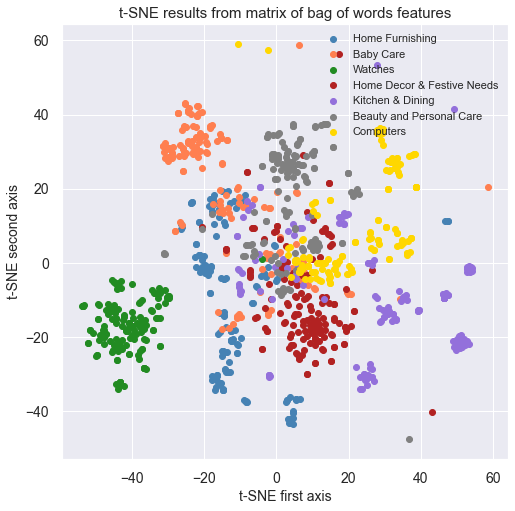

In [75]:
bow_tsne2,  bow_tsne2_cat = tsne_categories(bow_df, txt["level_1"], learning_rate=10, perplexity=15)

3 clusters are rather correctly separated (watches and baby care), the others are not well separated, although the products belonging to the same categories are orften close from each other.

fit time: 0.057s 
inertia: 161065 
Silhouette score: 0.431 
Davies-Bouldin score:0.809


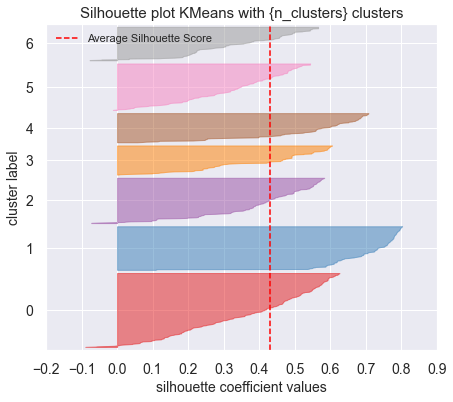

In [76]:
bow_tsne2_kmeans_labels, bow_tsne2_kmeans_centroids = kmeans_simple(bow_tsne2[["axis_1", "axis_2"]], n_clusters=7)

Although the silhouette score and Davies-Boulin scores are not very good, most clusters are well distinct. Except clusters1-2-3 that show important overlap.

t-SNE reduction to **3 dimensions** and corresponding KMeans clustering.

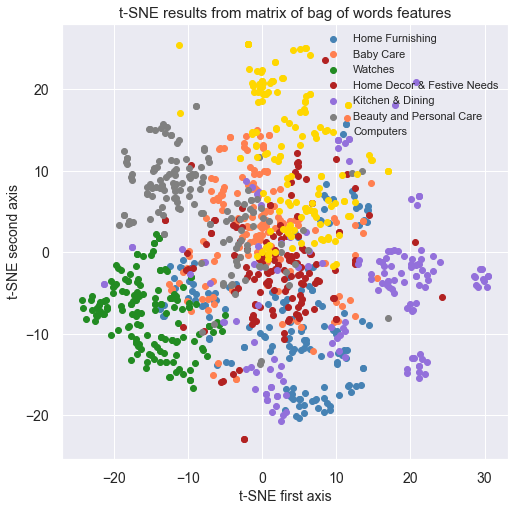

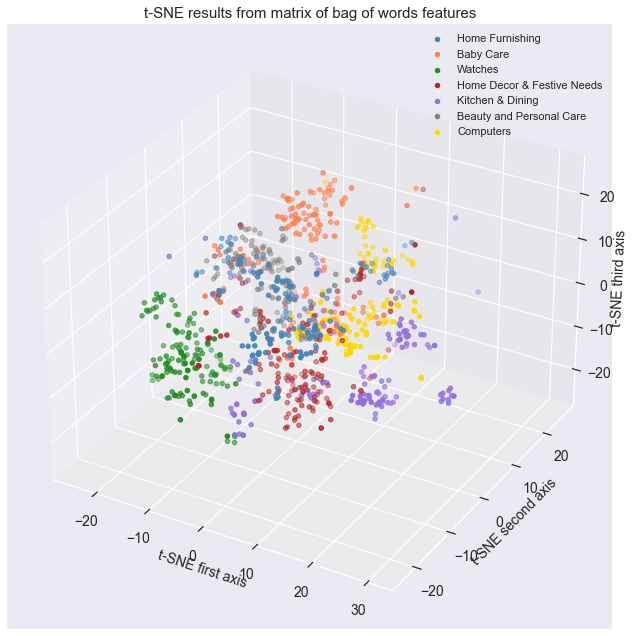

In [77]:
bow_tsne3, bow_tsne3_cat = tsne_categories(bow_df, txt["level_1"], n_components=3, learning_rate=20, perplexity=10)

The detection of categories is better with 3 dimensions (in the 2D visualization the clusters seem less well separated, but this is because we do not see the third dimension here). The clusters are more homogeneous.

fit time: 0.086s 
inertia: 94836 
Silhouette score: 0.319 
Davies-Bouldin score:1.003


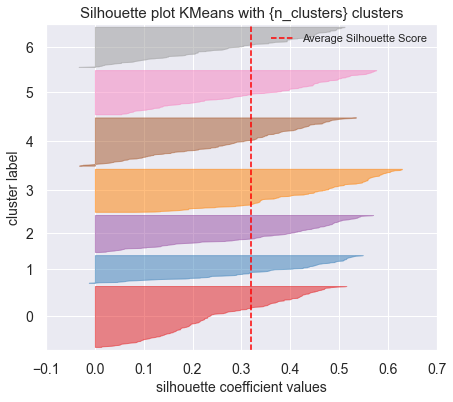

In [78]:
bow_tsne3_kmeans_labels, bow_tsne3_kmeans_centroids = kmeans_simple(bow_tsne3[["axis_1", "axis_2", "axis_3"]], n_clusters=7)

The results of the KMeans are also better, with a better individualisation fo the clusters (no overlap), although the score are lower than with 2 dimensions.

In [79]:
categories_comparison(txt_clean, "kmeans_labels_bow", bow_tsne3_kmeans_labels, "level_1")

Cluster 0
Home Decor & Festive Needs    104
Computers                      37
Kitchen & Dining               33
Beauty and Personal Care       26
Baby Care                      11
Home Furnishing                 1
Name: level_1, dtype: int64 

Cluster 1
Kitchen & Dining              83
Baby Care                      9
Home Decor & Festive Needs     3
Computers                      2
Name: level_1, dtype: int64 

Cluster 2
Baby Care                     89
Home Furnishing               24
Kitchen & Dining               6
Home Decor & Festive Needs     6
Beauty and Personal Care       4
Name: level_1, dtype: int64 

Cluster 3
Watches    150
Name: level_1, dtype: int64 

Cluster 4
Home Furnishing               111
Baby Care                      26
Home Decor & Festive Needs     15
Kitchen & Dining               10
Beauty and Personal Care        6
Name: level_1, dtype: int64 

Cluster 5
Beauty and Personal Care      107
Home Furnishing                14
Baby Care                      13
Ho

In [80]:
cat_names = ["Home Decor & Festive Needs", "Kitchen & Dining", "Baby Care", "Watches", "Home Furnishing", 
"Beauty and Personal Care", "Computers"]

clusters_to_true_labels(txt_clean, "kmeans_labels_bow", "kmeans_labels_bow_names", cat_names)

In [81]:
txt_clean.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description          level_1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                  level_2           level_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   
3               Bed Linen         Bedsheets   
4               Bed Linen         Bedsheets   

                                    name_description  kmeans_labels_bow  \
0  Elegance Polyester Multicolor Abstract Eyelet ...                  2   
1  Sathiyas Cotton Bath TowelSpecifications of Sa...                  4   
2  Eurospa Cotton Terry Face Towel SetKey Feature...                  5   
3  SANTOSH ROYAL FASHION Cotton Printed King size...                  4   
4  Jaipur Print Cotton Floral King sized Double B...                  4   

    kmeans_labels_bow_names  
0                 Baby Care  
1           Home Furnishing  
2  Beauty and Personal Care  
3           Home Furnishing  
4           Home Furnishing

In [82]:
ari_bow = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_bow_names"])
print(f"The adjusted rand score is {ari_bow:.2f}.")

The adjusted rand score is 0.48.


### With tf-idf

#### KMeans with 200 features

fit time: 0.098s 
inertia: 697 
Silhouette score: 0.184 
Davies-Bouldin score:2.148


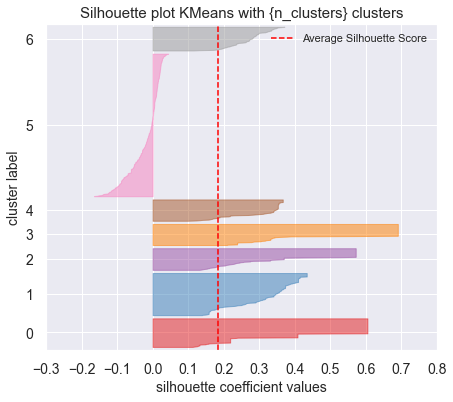

In [83]:
tf_idf_200_labels, tf_idf_200_centroids = kmeans_simple(tf_idf_200, 7)

In [84]:
tf_idf_200

abstract  adapter  add  additional  also  analog  art  baby  back  bath  \
0         0.24     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.65   
2         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.13   
3         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
4         0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
...        ...      ...  ...         ...   ...     ...  ...   ...   ...   ...   
1045      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.09  0.00   
1046      0.00     0.00 0.00        0.00  0.13    0.00 0.16  0.00  0.00  0.00   
1047      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1048      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   
1049      0.00     0.00 0.00        0.00  0.00    0.00 0.00  0.00  0.00  0.00   

      battery  beautiful  bed  bedsheet  best  black  blanket  blue  body  \
0        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.04   
1        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.16  0.00   
2        0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.00   
3        0.00       0.00 0.00      0.54  0.00   0.00     0.00  0.00  0.00   
4        0.00       0.00 0.30      0.33  0.00   0.00     0.00  0.00  0.00   
...       ...        ...  ...       ...   ...    ...      ...   ...   ...   
1045     0.00       0.00 0.00      0.00  0.00   0.00     0.00  0.00  0.00   
1046     0.00       0.00 0.00      0.00  0.09   0.00     0.00  0.00  0.00   
1047     0.00       0.00 0.00      0.00  0.24   0.00     0.00  0.00  0.00   
1048     0.00       0.00 0.00      0.00  0.10   0.00     0.00  0.00  0.00   
1049     0.00       0.00 0.00      0.00  0.24   0.00     0.00  0.00  0.00   

      bottle  box  boy  boys  brand  brass  bring  brown  capacity  care  \
0       0.00 0.03 0.00  0.00   0.03   0.00   0.05   0.00      0.00  0.00   
1       0.00 0.05 0.08  0.00   0.05   0.00   0.00   0.00      0.00  0.00   
2       0.00 0.03 0.00  0.06   0.07   0.00   0.06   0.00      0.00  0.10   
3       0.00 0.04 0.00  0.00   0.04   0.00   0.00   0.00      0.00  0.06   
4       0.00 0.03 0.00  0.00   0.03   0.00   0.00   0.00      0.00  0.04   
...      ...  ...  ...   ...    ...    ...    ...    ...       ...   ...   
1045    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1046    0.00 0.00 0.00  0.00   0.00   0.00   0.15   0.00      0.00  0.00   
1047    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1048    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   
1049    0.00 0.00 0.00  0.00   0.00   0.00   0.00   0.00      0.00  0.00   

      case  casual  cell  ceramic  charger  clean  cmbuy  code  coffee  \
0     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
2     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
3     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
4     0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
...    ...     ...   ...      ...      ...    ...    ...   ...     ...   
1045  0.00    0.00  0.00     0.00     0.00   0.10   0.00  0.00    0.00   
1046  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1047  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1048  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   
1049  0.00    0.00  0.00     0.00     0.00   0.00   0.00  0.00    0.00   

      collection  color  colour  combo  come  comfort  comforter  content  \
0           0.00   0.03    0.00   0.00  0.00     0.00       0.00     0.03   
1           0.00   0.05    0.00   0.00  0.00     0.00       0.00     0.06   
2           0.00   0.07    0.00   0.00  0.00     0.00       0.00     0.04  

In [85]:
categories_comparison(txt_clean, "kmeans_labels_tfidf_200", tf_idf_200_labels, "level_1")

Cluster 0
Computers                     52
Beauty and Personal Care      23
Kitchen & Dining              18
Baby Care                      6
Home Decor & Festive Needs     1
Name: level_1, dtype: int64 

Cluster 1
Watches    147
Name: level_1, dtype: int64 

Cluster 2
Home Decor & Festive Needs    75
Beauty and Personal Care       1
Name: level_1, dtype: int64 

Cluster 3
Beauty and Personal Care    74
Name: level_1, dtype: int64 

Cluster 4
Kitchen & Dining    74
Baby Care            1
Name: level_1, dtype: int64 

Cluster 5
Home Furnishing               150
Computers                      98
Home Decor & Festive Needs     74
Baby Care                      60
Kitchen & Dining               58
Beauty and Personal Care       52
Watches                         3
Name: level_1, dtype: int64 

Cluster 6
Baby Care    83
Name: level_1, dtype: int64 



In [86]:
cat_names = ["Computers", "Watches", "Home Decor & Festive Needs", "Beauty and Personal Care", "Kitchen & Dining",
    "Home Furnishing", "Baby Care"]

clusters_to_true_labels(txt_clean, "kmeans_labels_tfidf_200", "kmeans_labels_tfidf_200_names", cat_names)

In [87]:
ari_tf_idf_200 = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_tfidf_200_names"])
print(f"The adjusted rand score is {ari_tf_idf_200:.2f}.")

The adjusted rand score is 0.28.


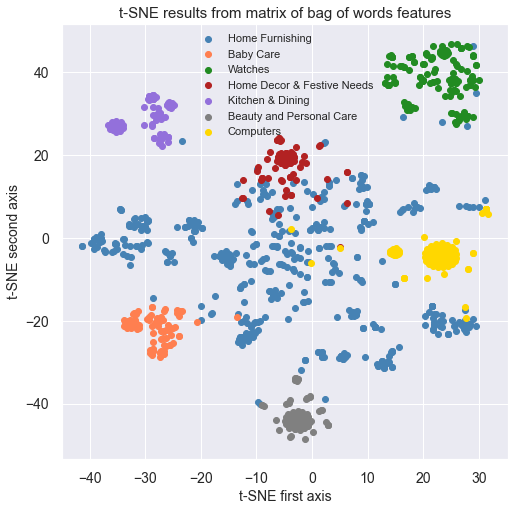

In [88]:
tf_idf_200_tsne2, tf_idf_200_tsne2_cat = tsne_categories(tf_idf_200, txt_clean["kmeans_labels_tfidf_200_names"], n_components=2)

#### KMeans with 3 features (2500 tf-idf features reducted on 3 t-SNE dimensions)

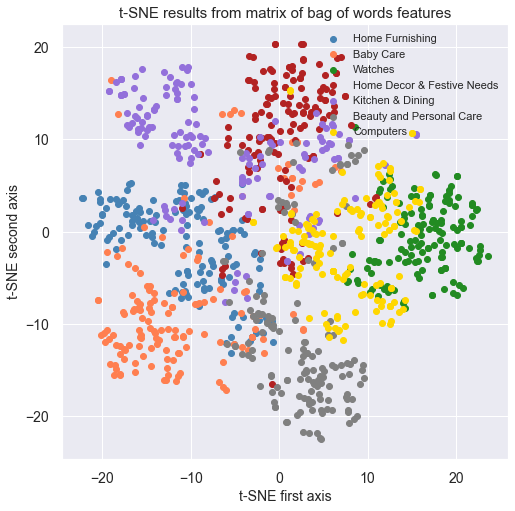

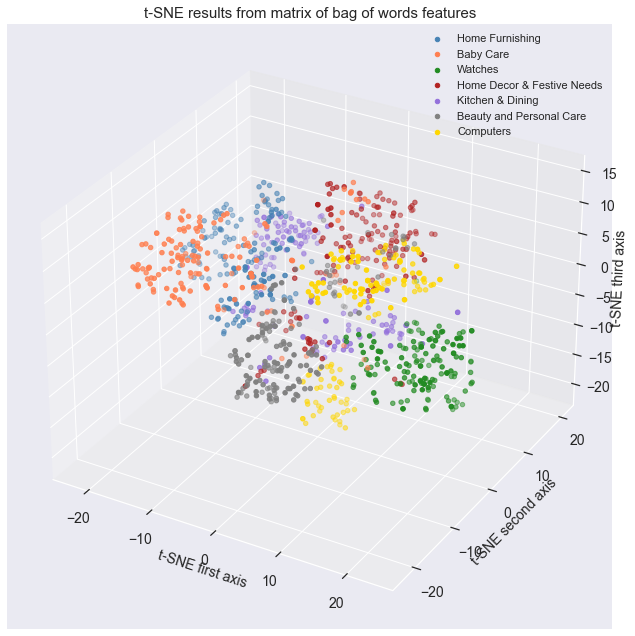

In [89]:
tf_idf_tsne3, tf_idf_tsne3_cat = tsne_categories(tf_idf_df, txt["level_1"], n_components=3, learning_rate=10)

fit time: 0.076s 
inertia: 62115 
Silhouette score: 0.354 
Davies-Bouldin score:0.896


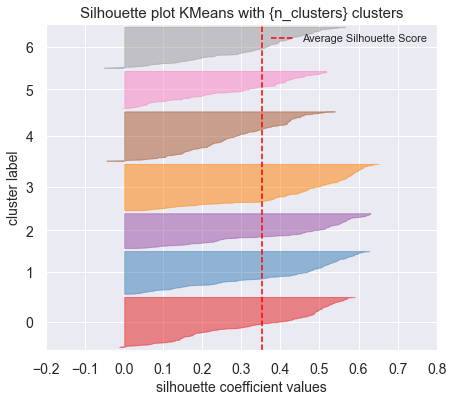

In [90]:
tf_idf_tsne3_kmeans_labels, tf_idf_tsne3_kmeans_centroids = kmeans_simple(tf_idf_tsne3[["axis_1", "axis_2", "axis_3"]], n_clusters=7)

In [91]:
categories_comparison(txt_clean, "kmeans_labels_tfidf_tsne3", tf_idf_tsne3_kmeans_labels, "level_1")

Cluster 0
Baby Care                   114
Home Furnishing              58
Kitchen & Dining              1
Beauty and Personal Care      1
Name: level_1, dtype: int64 

Cluster 1
Home Decor & Festive Needs    109
Beauty and Personal Care       20
Baby Care                       8
Computers                       7
Kitchen & Dining                3
Home Furnishing                 1
Watches                         1
Name: level_1, dtype: int64 

Cluster 2
Beauty and Personal Care      112
Home Furnishing                 5
Baby Care                       3
Home Decor & Festive Needs      1
Name: level_1, dtype: int64 

Cluster 3
Watches                       147
Computers                       8
Kitchen & Dining                3
Home Decor & Festive Needs      3
Name: level_1, dtype: int64 

Cluster 4
Kitchen & Dining              83
Home Furnishing               78
Baby Care                      8
Home Decor & Festive Needs     3
Name: level_1, dtype: int64 

Cluster 5
Computers           

In [92]:
cat_names = ["Baby Care", "Home Decor & Festive Needs", "Beauty and Personal Care",  "Watches", 
    "Home Furnishing", "Computers","Kitchen & Dining"]

clusters_to_true_labels(txt_clean, "kmeans_labels_tfidf_tsne3", "kmeans_labels_tfidf_tsne3_names", cat_names)

In [93]:
ari_tf_idf = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_tfidf_tsne3_names"])
print(f"The adjusted rand score is {ari_tf_idf:.2f}.")

The adjusted rand score is 0.49.


In [94]:
tf_idf_tsne3["kmeans_labels"] = txt_clean["kmeans_labels_tfidf_tsne3_names"]

In [95]:
tf_idf_tsne3_kmeans_labels = {}
tf_idf_tsne3_kmeans_labels["furnishing"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Home Furnishing"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["baby"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Baby Care"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["watches"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Watches"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["decor"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Home Decor & Festive Needs"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["kitchen"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Kitchen & Dining"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["beauty"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Beauty and Personal Care"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_tsne3_kmeans_labels["computers"] = tf_idf_tsne3[tf_idf_tsne3["kmeans_labels"]=="Computers"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]

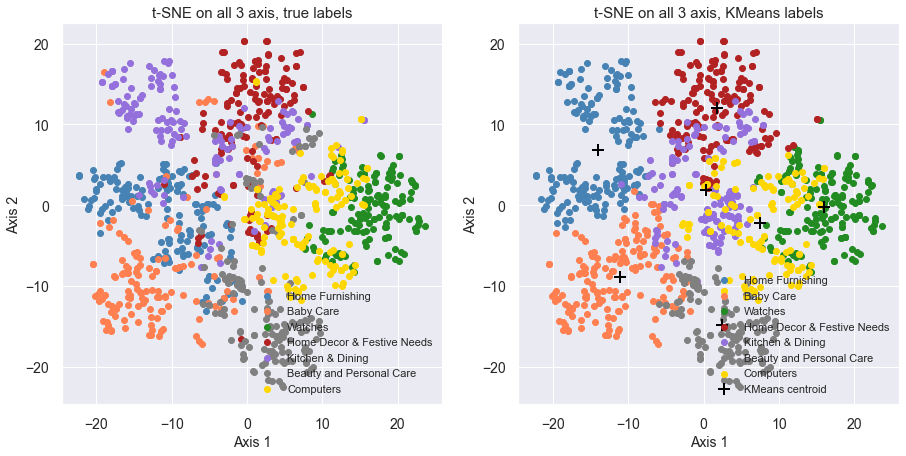

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

datas_p1 = [tf_idf_tsne3_cat["furnishing"], tf_idf_tsne3_cat["baby"], tf_idf_tsne3_cat["watches"], tf_idf_tsne3_cat["decor"], 
    tf_idf_tsne3_cat["kitchen"], tf_idf_tsne3_cat["beauty"], tf_idf_tsne3_cat["computers"]]
datas_p2 = [tf_idf_tsne3_kmeans_labels["furnishing"], tf_idf_tsne3_kmeans_labels["baby"], tf_idf_tsne3_kmeans_labels["watches"], tf_idf_tsne3_kmeans_labels["decor"], 
    tf_idf_tsne3_kmeans_labels["kitchen"], tf_idf_tsne3_kmeans_labels["beauty"], tf_idf_tsne3_kmeans_labels["computers"]]
colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

for data, color, label in zip(datas_p1, colors, categories):
    ax1.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
ax1.set_title('t-SNE on all 3 axis, true labels')
ax1.set_xlabel('Axis 1')
ax1.set_ylabel('Axis 2')
ax1.legend()

for data, color, label in zip(datas_p2, colors, categories):
    ax2.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
ax2.scatter(tf_idf_tsne3_kmeans_centroids[:, 0], tf_idf_tsne3_kmeans_centroids[:, 1], marker="+", color="black", 
    linewidth=2, s=150, zorder=3, label="KMeans centroid")
ax2.set_title('t-SNE on all 3 axis, KMeans labels')
ax2.set_xlabel('Axis 1')
ax2.set_ylabel('Axis 2')
ax2.legend();

#### KMeans with 3 features (200 features from tf-idf reducted on 3 t-SNE dimensions)

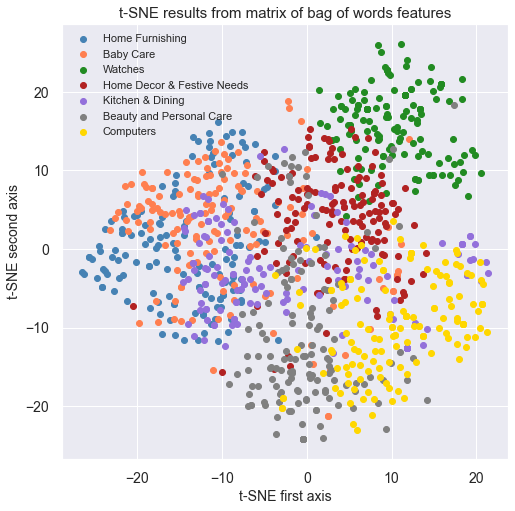

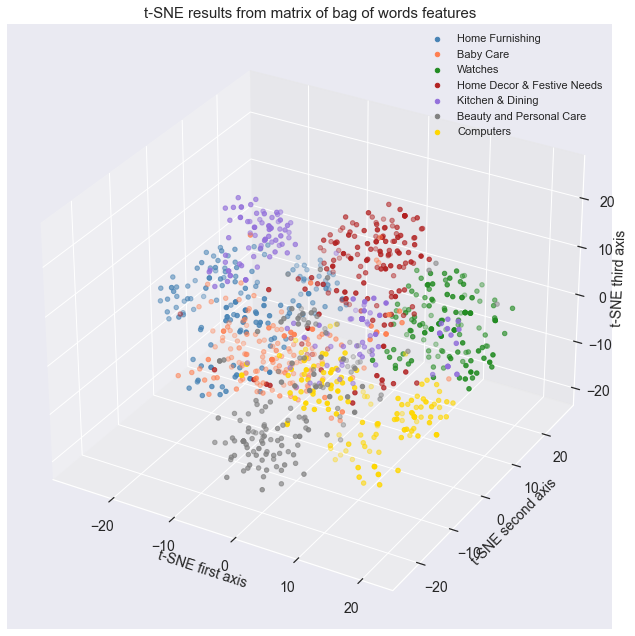

In [97]:
tf_idf_tsne3_200, tf_idf_tsne3_cat_200 = tsne_categories(tf_idf_200, txt["level_1"], n_components=3, perplexity=50, learning_rate=50)

fit time: 0.088s 
inertia: 95339 
Silhouette score: 0.330 
Davies-Bouldin score:0.974


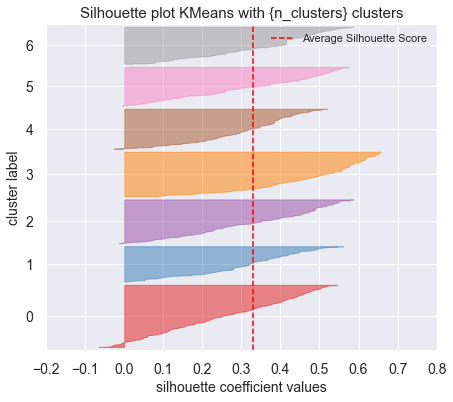

In [98]:
tf_idf_200_tsne3_kmeans_labels, tf_idf_200_tsne3_kmeans_centroids = kmeans_simple(tf_idf_tsne3_200[["axis_1", "axis_2", "axis_3"]], n_clusters=7)

In [99]:
categories_comparison(txt_clean, "kmeans_labels_tfidf_200_tsne3", tf_idf_200_tsne3_kmeans_labels, "level_1")

Cluster 0
Baby Care                     114
Home Furnishing                76
Beauty and Personal Care       16
Home Decor & Festive Needs      5
Kitchen & Dining                4
Computers                       1
Name: level_1, dtype: int64 

Cluster 1
Computers                     89
Kitchen & Dining              19
Home Decor & Festive Needs     9
Beauty and Personal Care       5
Watches                        1
Baby Care                      1
Name: level_1, dtype: int64 

Cluster 2
Home Decor & Festive Needs    124
Kitchen & Dining               12
Beauty and Personal Care        6
Baby Care                       5
Home Furnishing                 3
Computers                       2
Name: level_1, dtype: int64 

Cluster 3
Watches                     149
Baby Care                     3
Beauty and Personal Care      2
Kitchen & Dining              1
Name: level_1, dtype: int64 

Cluster 4
Kitchen & Dining              74
Home Furnishing               57
Home Decor & Festive Needs    

In [100]:
cat_names = ["Baby Care", "Computers", "Home Decor & Festive Needs", "Watches", "Home Furnishing", 
    "Beauty and Personal Care", "Kitchen & Dining"]

clusters_to_true_labels(txt_clean, "kmeans_labels_tfidf_200_tsne3", "kmeans_labels_tfidf_200_tsne3_names", cat_names)

In [101]:
ari_tf_idf_200_tsne3 = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_tfidf_200_tsne3_names"])
print(f"The adjusted rand score is {ari_tf_idf_200_tsne3:.2f}.")

The adjusted rand score is 0.47.


In [102]:
tf_idf_tsne3_200["kmeans_labels"] = txt_clean["kmeans_labels_tfidf_200_tsne3_names"]

In [103]:
tf_idf_200_tsne3_kmeans_labels = {}
tf_idf_200_tsne3_kmeans_labels["furnishing"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Home Furnishing"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["baby"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Baby Care"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["watches"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Watches"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["decor"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Home Decor & Festive Needs"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["kitchen"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Kitchen & Dining"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["beauty"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Beauty and Personal Care"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]
tf_idf_200_tsne3_kmeans_labels["computers"] = tf_idf_tsne3_200[tf_idf_tsne3_200["kmeans_labels"]=="Computers"][["axis_1", "axis_2", "axis_3", "kmeans_labels"]]

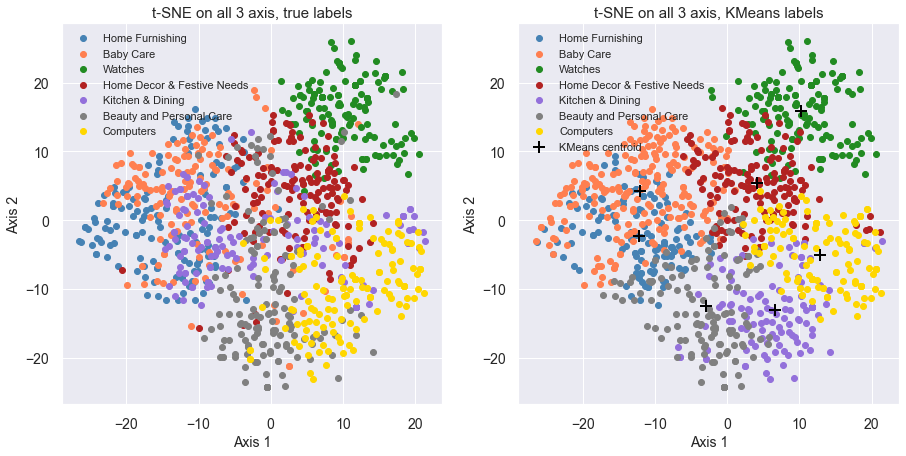

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

datas_p1 = [tf_idf_tsne3_cat_200["furnishing"], tf_idf_tsne3_cat_200["baby"], tf_idf_tsne3_cat_200["watches"], tf_idf_tsne3_cat_200["decor"], 
    tf_idf_tsne3_cat_200["kitchen"], tf_idf_tsne3_cat_200["beauty"], tf_idf_tsne3_cat_200["computers"]]
datas_p2 = [tf_idf_200_tsne3_kmeans_labels["furnishing"], tf_idf_200_tsne3_kmeans_labels["baby"], tf_idf_200_tsne3_kmeans_labels["watches"], 
    tf_idf_200_tsne3_kmeans_labels["decor"], tf_idf_200_tsne3_kmeans_labels["kitchen"], tf_idf_200_tsne3_kmeans_labels["beauty"], 
    tf_idf_200_tsne3_kmeans_labels["computers"]]
colors = ["steelblue", "coral", "forestgreen", "firebrick", "mediumpurple", "grey", "gold"]

for data, color, label in zip(datas_p1, colors, categories):
    ax1.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
ax1.set_title('t-SNE on all 3 axis, true labels')
ax1.set_xlabel('Axis 1')
ax1.set_ylabel('Axis 2')
ax1.legend()

for data, color, label in zip(datas_p2, colors, categories):
    ax2.scatter(data["axis_1"], data["axis_2"], color=color, label=label)
ax2.scatter(tf_idf_200_tsne3_kmeans_centroids[:, 0], tf_idf_200_tsne3_kmeans_centroids[:, 1], marker="+", color="black", 
    linewidth=2, s=150, zorder=3, label="KMeans centroid")
ax2.set_title('t-SNE on all 3 axis, KMeans labels')
ax2.set_xlabel('Axis 1')
ax2.set_ylabel('Axis 2')
ax2.legend();

#### CPA on the 200 features tf-idf

In [105]:
n_comp = 200

X = tf_idf_200.values
noms = tf_idf_200.index
features = tf_idf_200.columns

# Main axes calculation
acp = PCA(n_components=n_comp)
acp.fit(X)

PCA(n_components=200)

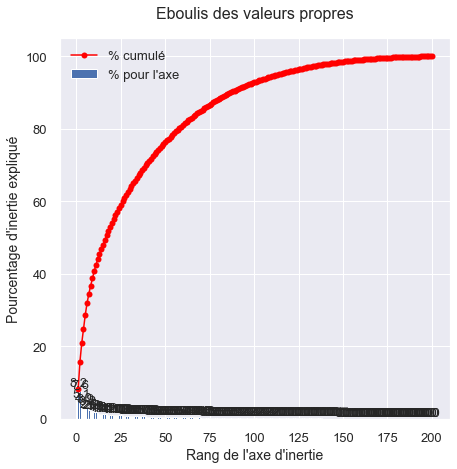

In [106]:
display_eigenvalues(acp, annotate=False)

In [107]:
n_comp = 200

X = tf_idf_200.values
noms = tf_idf_200.index
features = tf_idf_200.columns

# Main axes calculation
acp = PCA(n_components=n_comp)
acp.fit(X)

PCA(n_components=200)

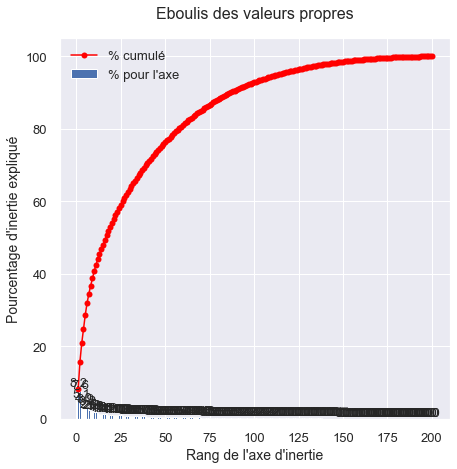

In [108]:
display_eigenvalues(acp, annotate=False)

### Word-embedding

#### Word2Vec

The cleaned, lemmatized and tokenized words we will use:

In [109]:
clean_corpus

[['elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtainkey',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'curtain',
  'enhance',
  'look',
  'interior',
  'curtain',
  'make',
  'high',
  'quality',
  'polyester',
  'fabric',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'make',
  'room',
  'environment',
  'romantic',
  'love',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'apparance',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'design',
  'surreal',
  'attention',
  'sure',
  'steal',
  'heart',
  'contemporary',
  'eyelet',
  'valance',
  'curtain',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',
  'morning',
  'welcome',
  'bright',
  'sun',
  'ray',
  'want',
  'wish',
  'good',
  'morn

In [110]:
# Define our parameters' model:
model = Word2Vec(sentences=clean_corpus, min_count=5)

In [111]:
# One example of a vectorized word:
vect_computer = model.wv['computer']
print(f"vector size: {vect_computer.size}")
vect_computer

vector size: 100


array([-0.15599923,  0.1310567 , -0.03979849, -0.01865964,  0.04916633,
       -0.2294149 ,  0.03994188,  0.41765836, -0.03600135, -0.14932935,
       -0.0889577 , -0.09995262, -0.03011794, -0.06381904,  0.0350372 ,
       -0.11328937,  0.07827085, -0.2214357 ,  0.06787605, -0.23715049,
        0.08928971,  0.17649549, -0.05437046, -0.12811668, -0.16874333,
       -0.05472291, -0.2565884 , -0.2145915 , -0.14981231,  0.0465774 ,
        0.17158699,  0.00490536,  0.00256446, -0.15306392, -0.10355563,
        0.20791544, -0.0227319 , -0.08946255, -0.03231806, -0.15609486,
       -0.07964516, -0.19202094,  0.12689956, -0.00956396,  0.10524461,
       -0.04484825,  0.01956988, -0.10239777,  0.07747955,  0.15860908,
        0.10013463, -0.21075825, -0.1114138 ,  0.01619173, -0.10567883,
        0.22809038,  0.11472344,  0.04164981, -0.27244872, -0.00865333,
        0.08220222,  0.06701561,  0.02040678,  0.04202797, -0.16949849,
        0.00713397,  0.04545809,  0.19855101, -0.09963641,  0.09

In [112]:
# Similarity between words of the corpus:
print(f"Cotton - elegance : {model.wv.similarity('cotton', 'elegance')}")
print(f"Cotton - computer : {model.wv.similarity('cotton', 'computer')}")
print(f"Cotton - baby : {model.wv.similarity('cotton', 'baby')}")

Cotton - elegance : 0.8658204078674316
Cotton - computer : 0.904267430305481
Cotton - baby : 0.9102721810340881


Same order of similarity between cotton and computer and cotton and elegance...strange.

In [113]:
# First 10 words in the model:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/1574 is replacement
word #1/1574 is genuine
word #2/1574 is day
word #3/1574 is watch
word #4/1574 is guarantee
word #5/1574 is mug
word #6/1574 is baby
word #7/1574 is design
word #8/1574 is analog
word #9/1574 is color


In [114]:
print(f"We have {len(model.wv)} words in our word2vec vocabulary.")

We have 1574 words in our word2vec vocabulary.


In [115]:
# Select words that are only in the Word2Vec vocabulary
clean_corpus_wv = clean_corpus.copy()
for i in range(len(clean_corpus)):
    clean_corpus_wv[i] = [w for w in clean_corpus[i] if w in model.wv.index_to_key]

In [116]:
clean_corpus_wv

[['elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtainkey',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'curtain',
  'enhance',
  'look',
  'interior',
  'curtain',
  'make',
  'high',
  'quality',
  'polyester',
  'fabric',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'make',
  'room',
  'love',
  'curtain',
  'ant',
  'anti',
  'elegant',
  'give',
  'home',
  'bright',
  'appeal',
  'design',
  'attention',
  'sure',
  'heart',
  'contemporary',
  'eyelet',
  'curtain',
  'slide',
  'draw',
  'first',
  'morning',
  'bright',
  'sun',
  'want',
  'wish',
  'good',
  'morning',
  'whole',
  'world',
  'draw',
  'create',
  'special',
  'moment',
  'beauty',
  'give',
  'bring',
  'home',
  'elegant',
  'curtain',
  'light',
  'room',
  'get',
  'right',
 

Now we replace each word of each document by its vector and calculate the mean vector for each document.

In [117]:
def mean_document_vector(corpus, model, vector_size, keyed_vector=False):

    all_doc_vec = []

    for doc in corpus:
        # Create zeros matrix size of document x size of word vector
        document = np.zeros((len(doc), vector_size))

        # Replace zeros by the word vectors
        for position, word in enumerate(doc):
            if keyed_vector:
                document[position] = model[word]
            else:
                document[position] = model.wv[word]

        # Make mean for each document
        doc_vec_mean = document.mean(axis=0)
        all_doc_vec.append(doc_vec_mean)

    all_doc_vec = np.asarray(all_doc_vec)

    return all_doc_vec

In [118]:
all_doc_vec = mean_document_vector(clean_corpus_wv, model, 100)

Direct use of document vectors in KMeans (100 features).

fit time: 0.060s 
inertia: 277 
Silhouette score: 0.348 
Davies-Bouldin score:1.027


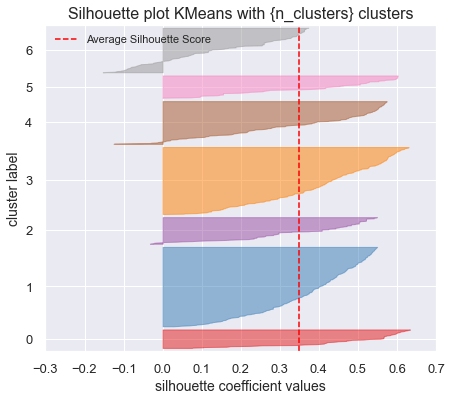

In [119]:
# Use our document vectors as input in the KMeans (100 features)
word2vec_kmeans_labels, word2vec_kmeans_centroids = kmeans_simple(all_doc_vec, n_clusters=7)

In [120]:
categories_comparison(txt_clean, "kmeans_labels_word2vec", word2vec_kmeans_labels, "level_1")

Cluster 0
Watches                       64
Home Decor & Festive Needs     1
Name: level_1, dtype: int64 

Cluster 1
Home Decor & Festive Needs    63
Home Furnishing               52
Beauty and Personal Care      46
Computers                     43
Kitchen & Dining              41
Baby Care                     27
Watches                        4
Name: level_1, dtype: int64 

Cluster 2
Computers                     35
Beauty and Personal Care      22
Home Decor & Festive Needs    21
Kitchen & Dining              15
Name: level_1, dtype: int64 

Cluster 3
Beauty and Personal Care      74
Computers                     57
Home Decor & Festive Needs    51
Kitchen & Dining              33
Baby Care                     17
Home Furnishing                1
Name: level_1, dtype: int64 

Cluster 4
Baby Care                     96
Home Furnishing               35
Home Decor & Festive Needs     7
Beauty and Personal Care       5
Kitchen & Dining               4
Computers                      1
Watch

Categories are too messed up to make a correspondance with true categories and calculate an ARI score.

Using t-SNE before KMeans to reduce the 100 dimensions to 3 dimensions.

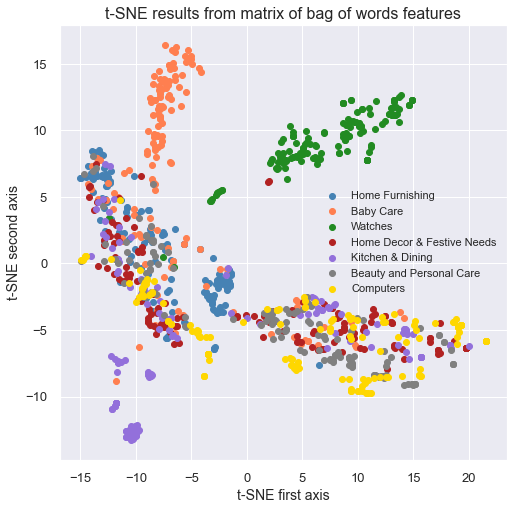

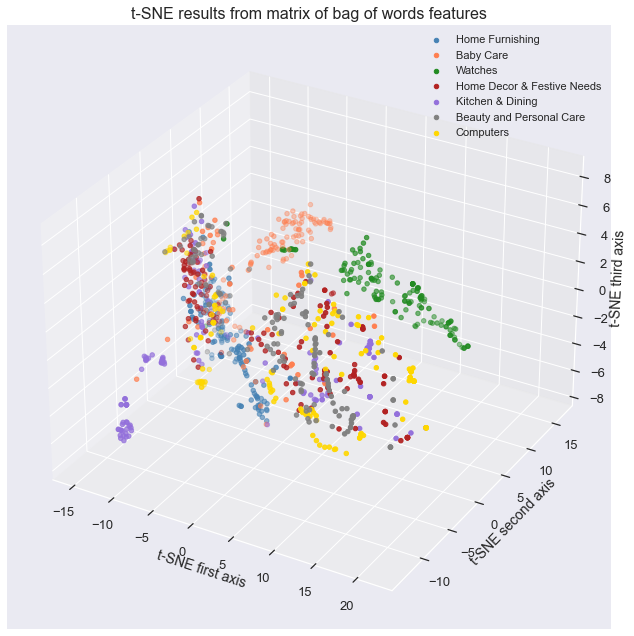

In [121]:
word2vec_tsne, word2vec_tsne_cat = tsne_categories(all_doc_vec, txt["level_1"], n_components=3)

We can see 3-4 partly well separated clusters, but with a large cluster mixing all categories in the center. The results are not very concluant.

fit time: 0.115s 
inertia: 20010 
Silhouette score: 0.425 
Davies-Bouldin score:0.854


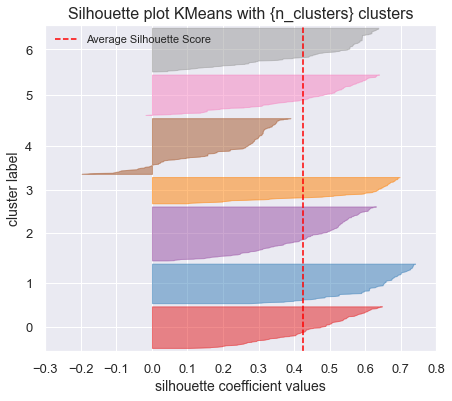

In [122]:
word2vec_tsne3_kmeans_labels, word2vec_tsne3_kmeans_centroids = kmeans_simple(word2vec_tsne[["axis_1", "axis_2", "axis_3"]], n_clusters=7)

In [123]:
categories_comparison(txt_clean, "kmeans_labels_word2vec_tsne3", word2vec_tsne3_kmeans_labels, "level_1")

Cluster 0
Home Decor & Festive Needs    39
Beauty and Personal Care      38
Kitchen & Dining              21
Baby Care                     17
Home Furnishing               15
Computers                     13
Watches                        2
Name: level_1, dtype: int64 

Cluster 1
Watches                       136
Home Decor & Festive Needs      2
Name: level_1, dtype: int64 

Cluster 2
Beauty and Personal Care      64
Home Decor & Festive Needs    42
Computers                     39
Kitchen & Dining              25
Baby Care                     15
Home Furnishing                3
Name: level_1, dtype: int64 

Cluster 3
Baby Care    81
Watches      11
Name: level_1, dtype: int64 

Cluster 4
Kitchen & Dining              67
Home Furnishing               62
Computers                     41
Home Decor & Festive Needs    12
Baby Care                      9
Beauty and Personal Care       3
Name: level_1, dtype: int64 

Cluster 5
Home Furnishing               70
Baby Care                     

In [124]:
cat_names = ["Home Decor & Festive Needs", "Beauty and Personal Care", "Watches", "Home Furnishing", "Computers",
    "Baby Care", "Kitchen & Dining"]

clusters_to_true_labels(txt_clean, "kmeans_labels_word2vec_tsne3", "kmeans_labels_word2vec_tsne3_names", cat_names)

In [125]:
ari_word2vec_tsne3 = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_word2vec_tsne3_names"])
print(f"The adjusted rand score is {ari_word2vec_tsne3:.2f}.")

The adjusted rand score is 0.26.


Let's try to get an image of the similarities of the corpus words. We will reduce their vectors dimensions and represent them in 2D with t-SNE.

In [126]:
def word2vec_tsne(model, nb_dim):

    """
    Operate a t-SNE with the specified number of dimensions on the vectors of Word2Vec specified model.
    Return x and y coordinates on the t-SNE axis and corresponding words.
    """

    # Extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    words = np.asarray(model.wv.index_to_key)

    # Reduce using t-SNE
    tsne = TSNE(n_components=nb_dim, random_state=0)
    vectors = tsne.fit_transform(vectors)

    # Get t-SNE coordinates and corresponding words
    x_val = [v[0] for v in vectors]
    y_val = [v[1] for v in vectors]

    return x_val, y_val, words

In [127]:
x_val, y_val, words = word2vec_tsne(model, 2)

In [128]:
# Select 30 words at random in the corpus:
random.seed(5)
indices = list(range(len(words)))
selected_indices = random.sample(indices, 25)

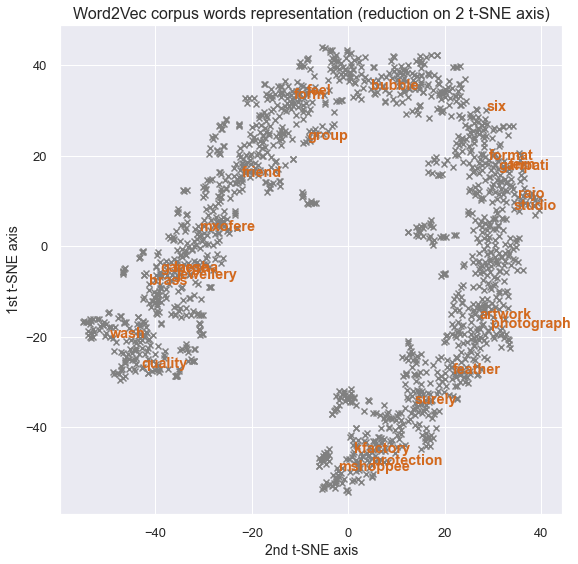

In [129]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.scatter(x_val, y_val, marker="x", color="grey")
for i in selected_indices:
        ax.annotate(words[i], (x_val[i], y_val[i]), fontsize="large", color="chocolate", fontweight="semibold")
ax.set_title("Word2Vec corpus words representation (reduction on 2 t-SNE axis)")
ax.set_xlabel("2nd t-SNE axis")
ax.set_ylabel("1st t-SNE axis");

In [130]:
trace_data = go.Scatter(x=x_val, y=y_val, mode="markers", text=words,
                        marker=dict(size=10, color="steelblue", line_color="white", line_width=1))

fig = go.Figure(data=trace_data)

fig.update_layout(title_text = "Word2Vec corpus words representation (reduction on 2 t-SNE axis)",
                    width=650, height=650,
                    xaxis=dict(linecolor='black', linewidth=1),
                    yaxis=dict(linecolor='black', linewidth=1),
                    margin=dict(l=50, r=50,b=50,t=80, pad=4))

fig.show()

With pre-trained Word2Vec models.

In [131]:
# Get the available models
info = gensim_api.info()

for model_name, model_data in sorted(info['models'].items()):
    print('%s (%d records): %s' % (model_name, model_data.get('num_records', -1), 
        model_data['description'][:80] + '...',))

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors of the movie matrix....
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets, 27B tokens, 1.2M vocab, uncased (https:...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https:/...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, ...
glove-wik

In [132]:
# More infos on the W2V Google News model:
word2vec_google_news_300_info = gensim_api.info("word2vec-google-news-300")
print(json.dumps(word2vec_google_news_300_info, indent=4))

{
    "num_records": 3000000,
    "file_size": 1743563840,
    "base_dataset": "Google News (about 100 billion words)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-google-news-300/__init__.py",
    "license": "not found",
    "parameters": {
        "dimension": 300
    },
    "description": "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
    "read_more": [
        "https://code.google.com/archive/p/word2vec/",
        "https://arxiv.org/abs/1301.3781",
        "https://arxiv.org/abs/1310.4546",
        "https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representatio

In [133]:
# If downloading archive needed
#path_w2v = os.path.join(path_to_txt_folder, "GoogleNews-vectors-negative300.bin")
#w2v_GN_300 = KeyedVectors.load_word2vec_format(path_w2v, binary=True)

In [134]:
w2v_GN_300 = gensim_api.load("word2vec-google-news-300")

In [135]:
w2v_GN_300["boy"]

array([ 2.35351562e-01,  1.65039062e-01,  9.32617188e-02, -1.28906250e-01,
        1.59912109e-02,  3.61328125e-02, -1.16699219e-01, -7.32421875e-02,
        1.38671875e-01,  1.15356445e-02,  1.87500000e-01, -2.91015625e-01,
        1.70898438e-02, -1.84570312e-01, -2.87109375e-01,  2.54821777e-03,
       -2.19726562e-01,  1.77734375e-01, -1.20605469e-01,  5.39550781e-02,
        3.78417969e-02,  2.49023438e-01,  1.76757812e-01,  2.69775391e-02,
        1.21093750e-01, -3.51562500e-01, -5.83496094e-02,  1.22070312e-01,
        5.97656250e-01, -1.60156250e-01,  1.08398438e-01, -2.40478516e-02,
       -1.16699219e-01,  3.58886719e-02, -2.37304688e-01,  1.15234375e-01,
        5.27343750e-01, -2.18750000e-01, -4.54101562e-02,  3.30078125e-01,
        3.75976562e-02, -5.51757812e-02,  3.26171875e-01,  6.74438477e-03,
        3.71093750e-01,  3.68652344e-02,  6.68945312e-02,  5.17578125e-02,
       -4.76074219e-02, -7.91015625e-02,  4.46777344e-02,  1.67968750e-01,
        5.51757812e-02, -

In [136]:
print(f"We have {len(vocabulary)} words in our whole corpus (including some badly cleaned words).")

We have 51618 words in our whole corpus (including some badly cleaned words).


In [137]:
common_vocabulary = set(vocabulary) & set(w2v_GN_300.index_to_key)
print(f"{len(common_vocabulary)} words of our corpus are in the Google pre-trained model, equivalent to {len(common_vocabulary)*100/len(vocabulary):.2f} %.")

3561 words of our corpus are in the Google pre-trained model, equivalent to 6.90 %.


Very few of our words are in the pre-trained model...

In [138]:
# Select words that are only in Word2Vec pre-trained vocabulary
clean_corpus_wv_google = clean_corpus.copy()
for i in range(len(clean_corpus)):
    clean_corpus_wv_google[i] = [w for w in clean_corpus[i] if w in w2v_GN_300.index_to_key]

In [139]:
clean_corpus_wv_google

[['elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'curtain',
  'enhance',
  'look',
  'interior',
  'curtain',
  'make',
  'high',
  'quality',
  'polyester',
  'fabric',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'make',
  'room',
  'environment',
  'romantic',
  'love',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'design',
  'surreal',
  'attention',
  'sure',
  'steal',
  'heart',
  'contemporary',
  'eyelet',
  'valance',
  'curtain',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',
  'morning',
  'welcome',
  'bright',
  'sun',
  'ray',
  'want',
  'wish',
  'good',
  'morning',
  'whole',
  'world',
  '

In [140]:
all_doc_vec_gn300 = mean_document_vector(clean_corpus_wv_google, w2v_GN_300, 300, keyed_vector=True)

t-SNE reduction then KMeans

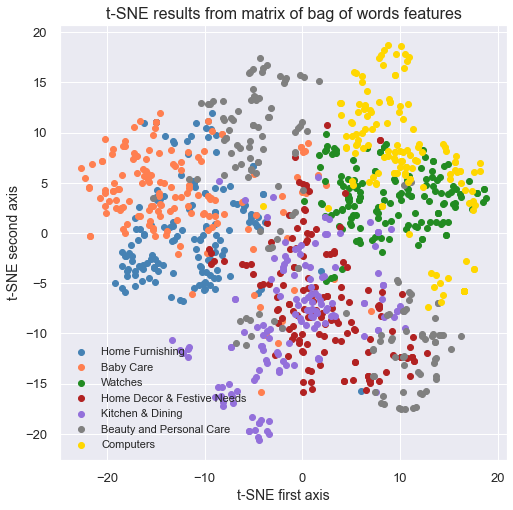

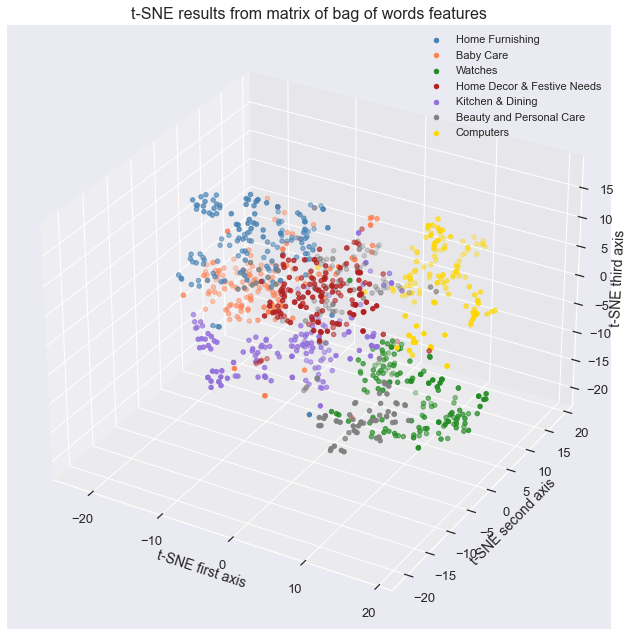

In [141]:
w2v_gn300_tsne, w2v_gn300_tsne_cat = tsne_categories(all_doc_vec_gn300, txt["level_1"], n_components=3, learning_rate=20, perplexity=20)

fit time: 0.067s 
inertia: 58123 
Silhouette score: 0.368 
Davies-Bouldin score:0.963


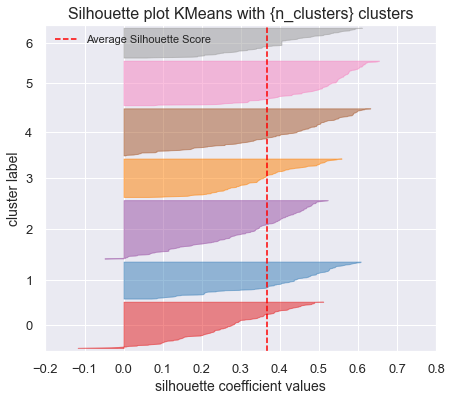

In [142]:
w2v_gn300_tsne3_kmeans_labels, w2v_gn300_tsne3_kmeans_centroids = kmeans_simple(w2v_gn300_tsne[["axis_1", "axis_2", "axis_3"]], n_clusters=7)

In [143]:
categories_comparison(txt_clean, "kmeans_labels_w2v_gn300_tsne3", w2v_gn300_tsne3_kmeans_labels, "level_1")

Cluster 0
Kitchen & Dining              118
Home Decor & Festive Needs     25
Baby Care                       8
Beauty and Personal Care        6
Home Furnishing                 4
Name: level_1, dtype: int64 

Cluster 1
Home Decor & Festive Needs    108
Beauty and Personal Care       10
Kitchen & Dining                6
Baby Care                       3
Home Furnishing                 2
Name: level_1, dtype: int64 

Cluster 2
Baby Care                     118
Beauty and Personal Care       61
Home Furnishing                19
Kitchen & Dining                3
Home Decor & Festive Needs      2
Name: level_1, dtype: int64 

Cluster 3
Home Furnishing    124
Baby Care            9
Computers            1
Name: level_1, dtype: int64 

Cluster 4
Computers                     122
Beauty and Personal Care       11
Baby Care                      11
Home Decor & Festive Needs     11
Kitchen & Dining                8
Watches                         1
Name: level_1, dtype: int64 

Cluster 5
Watches

In [144]:
cat_names = ["Kitchen & Dining", "Home Decor & Festive Needs", "Baby Care", "Home Furnishing", "Computers", 
    "Watches", "Beauty and Personal Care"]

clusters_to_true_labels(txt_clean, "kmeans_labels_w2v_gn300_tsne3", "kmeans_labels_w2v_gn300_tsne3_names", cat_names)

In [145]:
ari_w2v_gn300_tsne3 = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_w2v_gn300_tsne3_names"])
print(f"The adjusted rand score is {ari_w2v_gn300_tsne3:.2f}.")

The adjusted rand score is 0.57.


Not bad! Better than other models.

#### Doc2Vec

In [146]:
def doc2vec_simple(corpus, min_count=3, epochs=20, vector_size=100):
    """
    Compute Doc2Vec algorithm on the corpus with indicated parameters:
    - min_count (int) minimum number of occurences of a word to be included in the doc2vec
    - epochs (int) number of iterations of the model
    - vector_size (int) number of vectors to build for each documentation
    Return an array of size N x vector_size (with N number of documents in the corpus).
    """
    # Tag the documents and words of each document in the corpus:
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    # Build model and vocabulary:
    model = Doc2Vec(min_count=min_count, vector_size=vector_size, epochs=epochs)
    model.build_vocab(documents)

    # Train model (on the whole corpus)
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

    # Append vectors in a matrix:
    dv_matrix = model.dv[0]
    for i in range(1, len(documents)):
        dv_matrix = np.vstack([dv_matrix, model.dv[i]])

    return dv_matrix, model

Doc2Vec then KMeans with `vector_size=300`.

In [147]:
dv_matrix_300, model = doc2vec_simple(clean_corpus, min_count=3, vector_size=300, epochs=40)

In [148]:
print(f"Word 'table' appeared {model.wv.get_vecattr('table', 'count')} times in the corpus.")

Word 'table' appeared 69 times in the corpus.


In [149]:
# Vector for the first document of the model:
model.dv[0]

array([ 1.24307118e-01,  2.25506783e-01,  1.79698750e-01,  3.78908217e-01,
        1.32111773e-01,  6.89007819e-01, -7.43988037e-01, -4.24357355e-01,
        3.01657021e-01, -1.87236264e-01,  5.32842502e-02, -6.98550284e-01,
        7.52799749e-01, -2.06721514e-01, -5.90812624e-01,  1.18395641e-01,
       -2.43551493e-01, -4.26288188e-01, -1.82937860e-01,  4.23988134e-01,
       -5.10220826e-01,  8.77094492e-02,  1.34778798e-01, -1.41794547e-01,
        6.39342248e-01, -1.12973921e-01,  1.51511431e-01, -2.95089036e-01,
       -4.05517407e-03, -6.46131694e-01,  1.86622933e-01,  1.53976843e-01,
        1.48251265e-01,  3.87972832e-01,  3.24972361e-01, -3.68751317e-01,
       -1.08822286e-01, -4.27849740e-01,  1.13059068e-02,  3.88018876e-01,
        8.22685882e-02, -2.74529785e-01, -6.55683696e-01, -9.30735841e-02,
        3.44408840e-01, -1.07743368e-01, -4.73364955e-03,  8.04503188e-02,
        3.21757421e-02, -3.93332124e-01,  3.76408875e-01,  7.26901293e-02,
       -1.76956803e-01, -

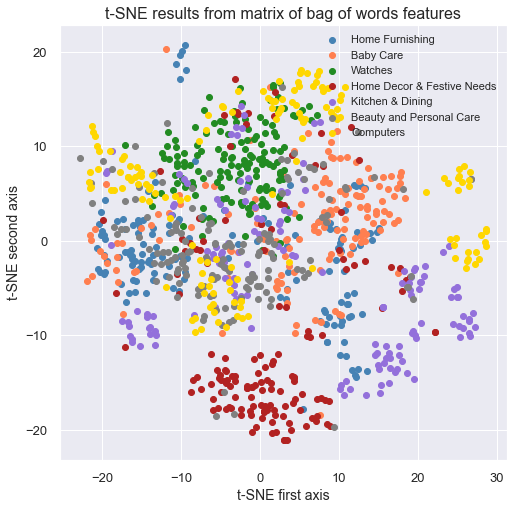

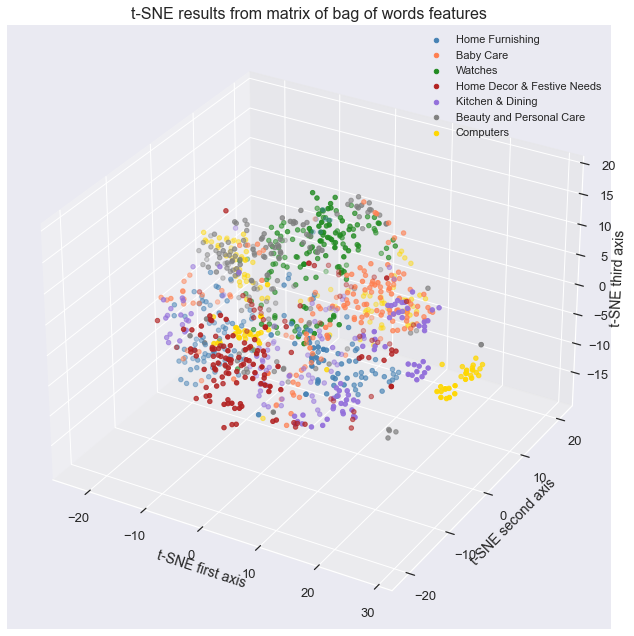

In [150]:
dv_300_tsne3, dv_300_tsne3_cat = tsne_categories(dv_matrix_300, txt["level_1"], n_components=3, learning_rate=50, perplexity=20)

fit time: 0.089s 
inertia: 71557 
Silhouette score: 0.303 
Davies-Bouldin score:1.043


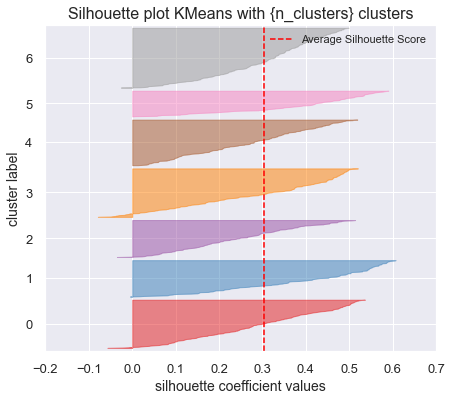

In [151]:
d2v_300_tsne3_kmeans_labels, d2v_300_tsne3_kmeans_centroids = kmeans_simple(dv_300_tsne3[["axis_1", "axis_2", "axis_3"]], 7)

In [152]:
categories_comparison(txt_clean, "kmeans_labels_d2v_300_tsne3", d2v_300_tsne3_kmeans_labels, "level_1")

Cluster 0
Watches                       92
Baby Care                     38
Beauty and Personal Care      33
Home Decor & Festive Needs     3
Home Furnishing                2
Name: level_1, dtype: int64 

Cluster 1
Home Decor & Festive Needs    94
Home Furnishing               15
Kitchen & Dining               8
Beauty and Personal Care       4
Baby Care                      4
Computers                      2
Name: level_1, dtype: int64 

Cluster 2
Beauty and Personal Care      62
Computers                     26
Kitchen & Dining              19
Home Decor & Festive Needs    11
Baby Care                      7
Home Furnishing                4
Name: level_1, dtype: int64 

Cluster 3
Kitchen & Dining              59
Baby Care                     48
Computers                     28
Home Furnishing               15
Home Decor & Festive Needs    11
Beauty and Personal Care       8
Name: level_1, dtype: int64 

Cluster 4
Kitchen & Dining              44
Home Furnishing               37
Baby 

In [153]:
cat_names = ["Home Furnishing", "Watches", "Computers", "Baby Care", "Beauty and Personal Care", "Kitchen & Dining", 
    "Home Decor & Festive Needs"]

clusters_to_true_labels(txt_clean, "kmeans_labels_d2v_300_tsne3", "kmeans_labels_d2v_300_tsne3_names", cat_names)

In [154]:
ari_doc2vec_tsne3 = adjusted_rand_score(txt_clean["level_1"], txt_clean["kmeans_labels_d2v_300_tsne3_names"])
print(f"The adjusted rand score is {ari_doc2vec_tsne3:.2f}.")

The adjusted rand score is 0.18.


Doc2Vec then KMeans with `vector_size=50`.

In [155]:
dv_matrix_50, model = doc2vec_simple(clean_corpus, min_count=3, vector_size=50, epochs=40)

fit time: 0.242s 
inertia: 7112 
Silhouette score: 0.280 
Davies-Bouldin score:2.118


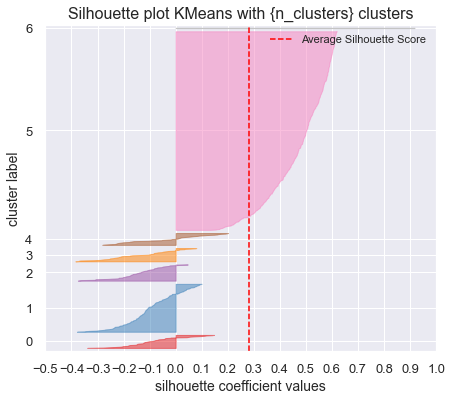

In [156]:
doc2vec_50_kmeans_labels, doc2vec_50_kmeans_centroids = kmeans_simple(dv_matrix_50, 7)

t-SNE with Doc2Vec vectors (50 dimensions reduced to 2).

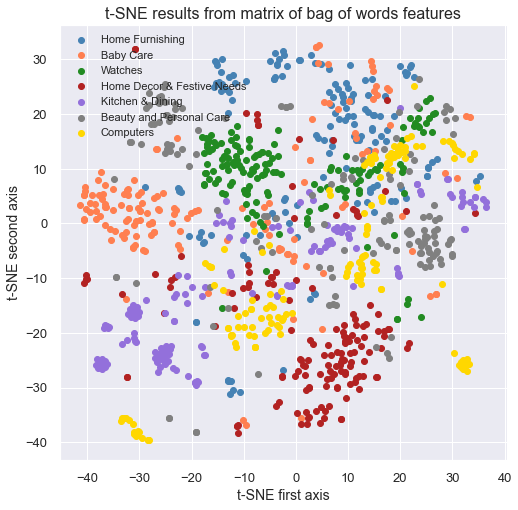

In [157]:
dv_50_tsne2, dv_50_tsne2_cat = tsne_categories(dv_matrix_50, txt["level_1"], n_components=2)

## Computer vision

### ORB

The general method is:
* Load and preprocess images (pass to grayscale and equalize histograms).
* Calculate descriptors using the ORB algorithm, gather all descriptors of all images in a matrix.
* Make a clustering of the descriptors.
* For each image, calculate an histogram counting the number of descriptors belonging to each cluster. This histogram represents the image features (visual bag-of-features). There are as many features per image as the number of clusters.
* (possible to make a CPA at this stage to lower computing time)
* Use the histograms as features in a clustering with k = number of categories to detect.
* Make a t-SNE to visualize the clustering results.

In [158]:
# Check path
path_to_images_folder

'E:/Mes Docs/Sciences/Cours/OpenclassroomsDS-ML/Projet6/images'

In [159]:
# Load images

# filenames = [img for img in glob.glob(path_to_images_folder + "/*.jpg")]
img_filenames = txt_clean["image"]
img_paths = [path_to_images_folder + "\\" + img for img in img_filenames]
img = [cv2.imread(img) for img in img_paths]

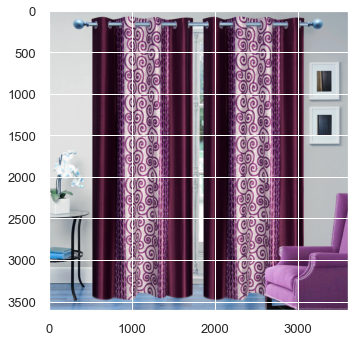

In [160]:
# Example first image
plt.imshow(img[0]);

In [161]:
# Preprocess images: grayscale and equalize
img = [cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY) for i in range(len(img))]
img = [cv2.equalizeHist(img[i]) for i in range(len(img))]

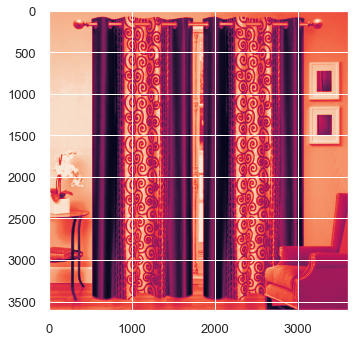

In [162]:
# Post preprocessing:
plt.imshow(img[0]);

In [163]:
def ORB_hist_tsne(images, kmeans_n_clusters, nfeatures=500, WTA_K=2, scale_factor=1.2, k="sqrt", 
    batch_size=1024, mbatch_max_iter=1000, n_comp=2, method="barnes_hut", init="pca", n_jobs=-2, 
    learning_rate=200, perplexity=30, random_state=None):
    """
    Use ORB algorithm to extract descriptors from input images.
    Group the descriptors with MiniBatch KMeans.
    Make histograms from the clustering results.
    Reduce histogram dimensions with t-SNE.
    Use t-SNE results in a KMeans to cluster images.
    Return the images histograms, the kmeans object and t-SNE results.

    images: iterable containing preprocessed images
    kmeans_n_clusters (int): number of categories to use for images clustering

    ORB parameters
    nfeatures (int): max number of features to select per image
    WTA_K (int): number of points that produce each element of the oriented BRIEF descriptor.
    scale_factor (float): pyramid decimation ratio (> 1)

    MiniBatch KMeans parameters:
    k: "sqrt", "10-times" or int. Number of clusters. If "sqrt", take the squared root of the 
        number of descriptors. If "10-time", take 10 times the number of image categories. 
        Or specify number of clusters (int).
    batch_size (int): MiniBatch size
    mbatch_max_iter (int): Max number of iterations

    t-SNE parameters
    n_comp (int): number of components
    method (str): "barnes_hut" (by default) or "exact"
    init (str): initialisation, default is "pca"
    n_jobs (int): The number of parallel jobs to run for neighbors search.
    learning_rate (int): Usually in the range [10.0, 1000.0].
    perplexity (int): Related to the number of nearest neighbors that is used in other 
    manifold learning algorithms. Usually in the range [5.0, 50.0].
    """

    # Create ORB object
    orb = cv2.ORB_create(nfeatures=nfeatures, WTA_K=WTA_K, scaleFactor=scale_factor)

    # Get descriptors in an array, each line being a descriptor
    _, des = orb.detectAndCompute(images[0], None)
    for i in range(1, len(images)):
        _, des_new = orb.detectAndCompute(images[i], None)
        des = np.vstack([des, des_new])
    
    print(f"We have a total of {des.shape[0]} descriptors. Each descriptor is a vector with {des.shape[1]} values.")

    # Select number of clusters
    if k=="sqrt":
        k = int(round(np.sqrt(len(des))))
    if k=="10-times":
        k = 10 * kmeans_n_clusters
    if type(k) is int:
        pass
    
    print(f"We will use {k} clusters to group the descriptors.")
    
    # Using Mini Batch KMeans to cluster the descriptors
    t0 = time()
    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, max_iter=mbatch_max_iter, random_state=random_state).fit(des)
    t1 = time()-t0
    print(f"Mini Batch KMeans fit time : {t1:.2f}s.")

    # Make an histogram for each image containing the number of descriptors attributed to each clusters
    histograms = np.zeros((len(images), k))

    # For each image
    for i in range(len(images)):

        img_hist = np.zeros(k)
        # Get descriptors, predict their cluster
        _, img_des = orb.detectAndCompute(images[i], None)
        nb_des = len(img_des)
        clusters_des = mb_kmeans.predict(img_des)
        if nb_des==0:
            print(f"No image descriptors at image {i}")
        # For each descriptor, increases the corresponding cluster count by one
        # Normalize by the number of descriptors of the image (in case it varies between images) 
        for j in clusters_des:
            img_hist[j] += 1/nb_des

        # Replace the zeros by the image histogram in the numpy array
        histograms[i] = img_hist
    
    print(f"Computed {histograms.shape[0]} histograms of length {histograms.shape[1]}.")
    
    # t_SNE dimensions reduction and visualization
    tsne_results = TSNE(n_components=n_comp, init=init, method=method, n_jobs=n_jobs, random_state=random_state, 
        learning_rate=learning_rate, perplexity=perplexity).fit_transform(histograms)
    
    # Kmeans on t-SNE results
    t0 = time()
    kmeans = KMeans(n_clusters=kmeans_n_clusters,random_state=random_state).fit(tsne_results)
    t1 = time()-t0
    print(f"KMeans fit time : {t1:.2f}s.")

    # Plot silhouettes
    fig, ax = plt.subplots(figsize=(7, 6))
    visualizer = SilhouetteVisualizer(KMeans(kmeans_n_clusters, random_state=0),
        title='Silhouette plot KMeans with {n_clusters} clusters')
    visualizer.fit(tsne_results)
    visualizer.finalize()

    tsne_results = pd.DataFrame(tsne_results)
    tsne_results["labels"] = kmeans.labels_

    # Plot t-SNE results with KMeans labels
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.scatterplot(ax=ax, x=tsne_results[0], y=tsne_results[1], hue=tsne_results["labels"], palette=sns.color_palette("husl", 7))
    ax.set_title("t-SNE results from matrix of bag of visual words features (ORB)")
    ax.set_xlabel("t-SNE first axis")
    ax.set_ylabel("t-SNE second axis")
    ax.legend();

    return histograms, kmeans, tsne_results


We have a total of 520179 descriptors. Each descriptor is a vector with 32 values.
We will use 721 clusters to group the descriptors.
Mini Batch KMeans fit time : 22.22s.
Computed 1050 histograms of length 721.
KMeans fit time : 0.07s.


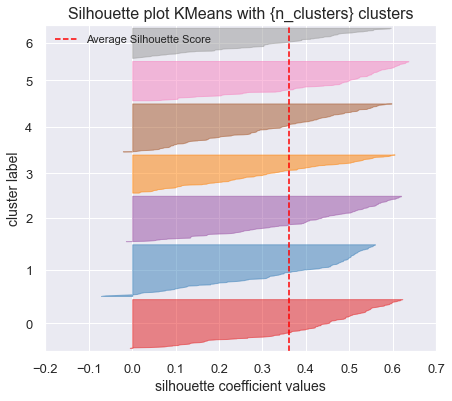

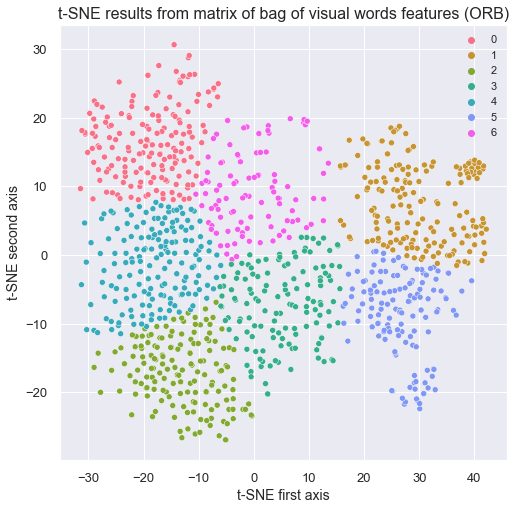

In [164]:
histograms_base, kmeans_base, tsne_results_base = ORB_hist_tsne(img, 7, random_state=0)

In [165]:
#n_comp = 20

#X = histograms_df.values
#noms = histograms_df.index
#features = histograms_df.columns

# Main axes calculation
#acp = PCA(n_components=n_comp)
#acp.fit(X)

In [166]:
#display_eigenvalues(acp)

In [167]:
#histograms_reduced = acp.fit_transform(histograms_df)

In [168]:
#histograms_reduced.shape

In [169]:
categories_comparison(txt_clean, "img_kmeans_labels_orb_tsne2", kmeans_base.labels_, "level_1")

Cluster 0
Beauty and Personal Care      42
Baby Care                     30
Watches                       24
Kitchen & Dining              21
Home Furnishing               21
Computers                     16
Home Decor & Festive Needs    16
Name: level_1, dtype: int64 

Cluster 1
Computers                     56
Kitchen & Dining              49
Baby Care                     21
Watches                       17
Home Furnishing               17
Home Decor & Festive Needs    12
Beauty and Personal Care       8
Name: level_1, dtype: int64 

Cluster 2
Beauty and Personal Care      41
Home Furnishing               32
Watches                       30
Home Decor & Festive Needs    20
Computers                     14
Baby Care                     13
Kitchen & Dining               8
Name: level_1, dtype: int64 

Cluster 3
Home Decor & Festive Needs    33
Watches                       27
Kitchen & Dining              24
Beauty and Personal Care      17
Computers                     13
Baby Care   

In [170]:
cat_names = ["Watches", "Computers", "Beauty and Personal Care",  "Home Furnishing", "Baby Care", "Kitchen & Dining", 
    "Home Decor & Festive Needs"]

clusters_to_true_labels(txt_clean, "img_kmeans_labels_orb_tsne2", "img_kmeans_labels_orb_tsne2_names", cat_names)

In [171]:
ari_orb_tsne2 = adjusted_rand_score(txt_clean["level_1"], txt_clean["img_kmeans_labels_orb_tsne2_names"])
print(f"The adjusted rand score is {ari_orb_tsne2:.2f}.")

The adjusted rand score is 0.04.


Looking for better params with ORB...

We have a total of 520179 descriptors. Each descriptor is a vector with 32 values.
We will use 721 clusters to group the descriptors.
Mini Batch KMeans fit time : 17.78s.
Computed 1050 histograms of length 721.
KMeans fit time : 0.07s.


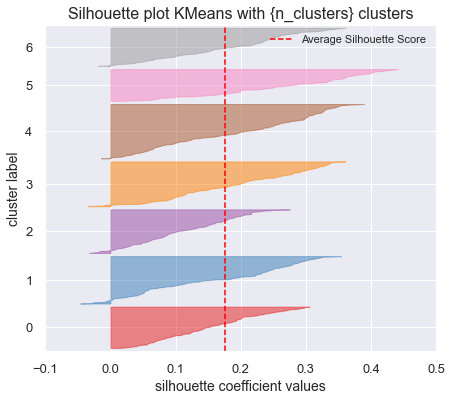

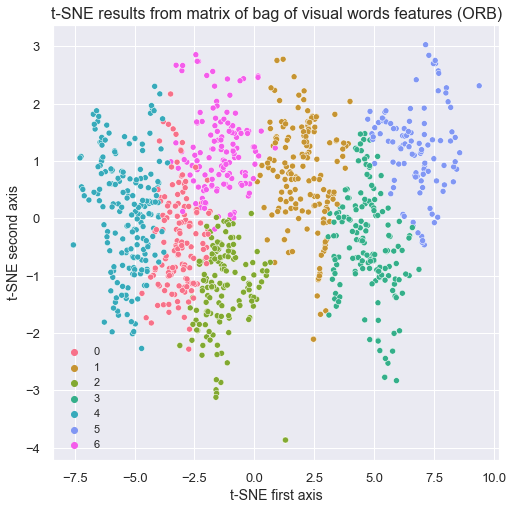

In [172]:
histo_refined, kmeans_refined, tsne_refined = ORB_hist_tsne(img, 7, WTA_K=4, n_comp=10, method="exact", 
    learning_rate=10, perplexity=20, random_state=0)

In [173]:
categories_comparison(txt_clean, "img_kmeans_labels_orb_refined", kmeans_refined.labels_, "level_1")

Cluster 0
Home Furnishing               36
Baby Care                     25
Watches                       22
Beauty and Personal Care      21
Home Decor & Festive Needs    18
Kitchen & Dining              13
Computers                      9
Name: level_1, dtype: int64 

Cluster 1
Watches                       37
Kitchen & Dining              34
Home Decor & Festive Needs    32
Computers                     20
Baby Care                     16
Beauty and Personal Care      13
Home Furnishing               13
Name: level_1, dtype: int64 

Cluster 2
Beauty and Personal Care      35
Watches                       25
Computers                     24
Baby Care                     24
Kitchen & Dining              17
Home Furnishing               14
Home Decor & Festive Needs    13
Name: level_1, dtype: int64 

Cluster 3
Home Decor & Festive Needs    39
Baby Care                     27
Kitchen & Dining              24
Computers                     21
Watches                       16
Beauty and P

In [174]:
cat_names = ["Beauty and Personal Care", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", 
    "Baby Care", "Watches", "Computers"]

clusters_to_true_labels(txt_clean, "img_kmeans_labels_orb_refined", "img_kmeans_labels_orb_refined_names", cat_names)

In [175]:
ari_orb_tsne_refined = adjusted_rand_score(txt_clean["level_1"], txt_clean["img_kmeans_labels_orb_refined_names"])
print(f"The adjusted rand score is {ari_orb_tsne_refined:.2f}.")

The adjusted rand score is 0.03.


## Use both NLP and computer vision to categorized products

We will use the 3 t-SNE axis from word2vec pre-trained model and the t-SNE dimensions obtained from ORB descriptors and histograms together with a KMeans clustering.

In [183]:
nlp_cv_features = pd.concat([w2v_gn300_tsne[["axis_1", "axis_2", "axis_3"]], tsne_results_base[[0, 1]]], axis=1)

In [186]:
nlp_cv_features.head()

axis_1  axis_2  axis_3      0      1
0  -14.74   -3.74    3.07 -25.80 -16.79
1  -11.74    8.09    4.42 -27.13  -6.08
2  -10.11    8.19    3.92 -10.89  -1.62
3  -10.01    3.99    6.98 -17.94 -13.24
4   -9.94    3.94    6.08 -17.31   2.25

In [184]:
t0 = time()
kmeans_all = KMeans(n_clusters=7,random_state=0).fit(nlp_cv_features)
t1 = time()-t0
print(f"KMeans fit time : {t1:.2f}s.")

KMeans fit time : 0.12s.


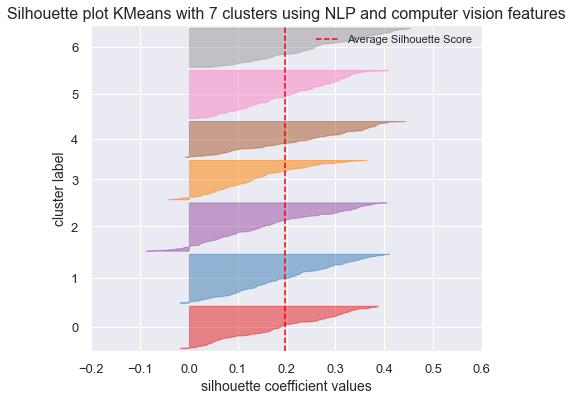

In [185]:
fig, ax = plt.subplots(figsize=(7, 6))
visualizer = SilhouetteVisualizer(KMeans(7, random_state=0),
    title='Silhouette plot KMeans with 7 clusters using NLP and computer vision features')
visualizer.fit(nlp_cv_features)
visualizer.finalize()

In [190]:
# t_SNE dimensions reduction and visualization
tsne_results_all = TSNE(n_components=2, init="pca", n_jobs=-2, random_state=0).fit_transform(nlp_cv_features)

In [191]:
nlp_cv_features["labels"] = kmeans_all.labels_

In [196]:
tsne_results_all = pd.DataFrame(tsne_results_all)

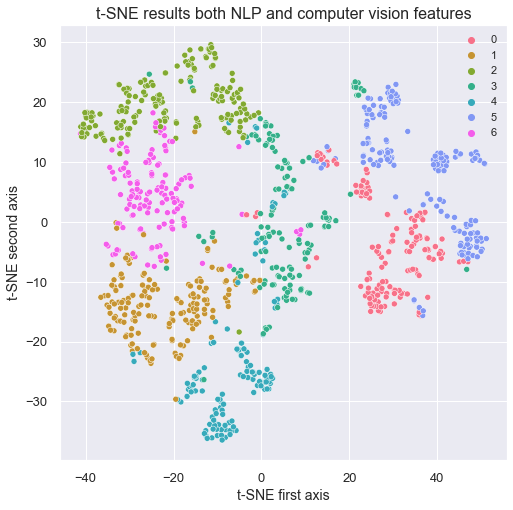

In [198]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, x=tsne_results_all[0], y=tsne_results_all[1], hue=nlp_cv_features["labels"], palette=sns.color_palette("husl", 7))
ax.set_title("t-SNE results both NLP and computer vision features")
ax.set_xlabel("t-SNE first axis")
ax.set_ylabel("t-SNE second axis")
ax.legend();

In [199]:
categories_comparison(txt_clean, "nlp_img_kmeans_labels", kmeans_all.labels_, "level_1")

Cluster 0
Baby Care                     40
Beauty and Personal Care      22
Home Furnishing               22
Kitchen & Dining              19
Computers                     18
Home Decor & Festive Needs    14
Watches                       12
Name: level_1, dtype: int64 

Cluster 1
Home Furnishing               63
Home Decor & Festive Needs    42
Baby Care                     27
Kitchen & Dining              17
Beauty and Personal Care      17
Computers                      4
Name: level_1, dtype: int64 

Cluster 2
Watches                       45
Beauty and Personal Care      38
Kitchen & Dining              25
Computers                     23
Home Decor & Festive Needs    18
Baby Care                     13
Home Furnishing                6
Name: level_1, dtype: int64 

Cluster 3
Watches                       39
Computers                     30
Home Decor & Festive Needs    27
Kitchen & Dining              19
Beauty and Personal Care      13
Home Furnishing                5
Baby Care   

In [200]:
cat_names = ["Beauty and Personal Care", "Home Furnishing", "Watches", "Home Decor & Festive Needs", "Kitchen & Dining", 
"Computers", "Baby Care"]

clusters_to_true_labels(txt_clean, "nlp_img_kmeans_labels", "nlp_img_kmeans_labels_names", cat_names)

In [201]:
ari_all = adjusted_rand_score(txt_clean["level_1"], txt_clean["nlp_img_kmeans_labels_names"])
print(f"The adjusted rand score is {ari_all:.2f}.")

The adjusted rand score is 0.11.
